# Evolution, répartition et prévision du nombre de points de recharge

In [95]:
#Import des principales librairies Python
import random
import requests

import geopandas as gpd
from matplotlib import pyplot as plt
import pandas as pd
import plotly.figure_factory as ff
from prophet import Prophet
import seaborn as sns
%matplotlib inline

## Traitement des données sur les points de charge

Ce jeu de données présente le nombre total de points de charge en France continentale : [Dataset ENEDIS](https://data.enedis.fr/explore/dataset/nombre-total-de-points-de-charge/information/?dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiU1VNIiwieUF4aXMiOiJzb2NpZXRlIiwic2NpZW50aWZpY0Rpc3BsYXkiOnRydWUsImNvbG9yIjoiI0E2QjlFNCJ9LHsidHlwZSI6ImNvbHVtbiIsImZ1bmMiOiJTVU0iLCJ5QXhpcyI6InBhcnRpY3VsaWVyIiwic2NpZW50aWZpY0Rpc3BsYXkiOnRydWUsImNvbG9yIjoiI0ZDOEQ2MiJ9LHsidHlwZSI6ImNvbHVtbiIsImZ1bmMiOiJTVU0iLCJ5QXhpcyI6ImFjY2Vzc2libGVfYXVfcHVibGljIiwic2NpZW50aWZpY0Rpc3BsYXkiOnRydWUsImNvbG9yIjoiIzY2QzJBNSJ9XSwieEF4aXMiOiJ0cmltZXN0cmUiLCJtYXhwb2ludHMiOjUwLCJzb3J0IjoiIiwic3RhY2tlZCI6Im5vcm1hbCIsImNvbmZpZyI6eyJkYXRhc2V0Ijoibm9tYnJlLXRvdGFsLWRlLXBvaW50cy1kZS1jaGFyZ2UiLCJvcHRpb25zIjp7fX19XSwidGltZXNjYWxlIjoiIiwic2luZ2xlQXhpcyI6dHJ1ZSwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&sort=-trimestre).

Les points de charge sont matérialisés par un socle de prise sur lequel un véhicule électrique peut potentiellement se brancher. Une borne de recharge peut comporter un ou plusieurs points de charge. Les données présentées segmentent les points de charge en trois typologies :

- Les points de charge « accessible au public » correspondent aux points de charge accessibles dans les commerces (supermarché, concession automobile…), parking, sites publics ou stations en voirie.
- Les points de charge « particulier » sont des points de charges privés localisés dans le résidentiel collectif (immeubles, copropriétés…) ou individuel (pavillons).
- Les points de charge « société » sont des points de charge privés localisés dans les sociétés et réservés à l’activité de la société ou à la recharge des véhicules électriques des employés.

Le jeu de données a été élaboré par Enedis à partir de ses données propres combinées avec certaines données externes, issues des sociétés Girève et AAA Data. Les données sur les points de charge « particulier » et « société » sont une reconstitution de l’existant construite par Enedis sur la base d’hypothèses. Ces hypothèses s’appuient sur l’évolution du marché du véhicule électrique.

In [2]:
irve_type = pd.read_csv('raw_data/nombre-total-de-points-de-charge.csv', sep=';')
irve_type = irve_type.sort_values('Trimestre').reset_index(drop=True)
irve_type

Trimestre  Accessible au public  Particulier  Société
0    2015 T1                  8478        25638    34746
1    2015 T2                 10086        29662    37933
2    2015 T3                 10928        32278    38681
3    2015 T4                 11113        37448    42891
4    2016 T1                 12830        43284    48013
5    2016 T2                 13861        48412    52015
6    2016 T3                 12859        52052    55309
7    2016 T4                 16220        57039    59408
8    2017 T1                 17423        62957    63757
9    2017 T2                 19750        68509    68930
10   2017 T3                 20688        73404    73713
11   2017 T4                 19309        79807    78881
12   2018 T1                 26325        86681    84921
13   2018 T2                 22283        92537    90950
14   2018 T3                 24319        97164    96616
15   2018 T4                 26254       106839   104895
16   2019 T1                 27516       115690   113101
17   2019 T2                 27668       123368   118974
18   2019 T3                 29545       132275   125667
19   2019 T4                 30203       144123   135563
20   2020 T1                 31081       172822   167797
21   2020 T2                 32648       192823   180499
22   2020 T3                 33369       222346   198437
23   2020 T4                 34686       267371   237863
24   2021 T1                 37491       307174   269327
25   2021 T2                 43699       359188   307269
26   2021 T3                 49086       402361   331981
27   2021 T4                 53667       465424   368355
28   2022 T1                 57732       515435   392504
29   2022 T2                 64546       575686   420774
30   2022 T3                 71630       623836   446585
31   2022 T4                 82107       688060   493648

In [3]:
#Calcul des évolutions en % entre chaque trimestre

irve_type['%Public'] = irve_type['Accessible au public'].pct_change().fillna(0)
irve_type['%Particulier'] = irve_type['Particulier'].pct_change().fillna(0)
irve_type['%Société'] = irve_type['Société'].pct_change().fillna(0)



In [4]:
from typing import Tuple

trimestre_mapping={'T1' : '31-03',
                    'T2' : '30-06',
                    'T3' : '30-09',
                    'T4' : '31-12'}

def transformation_trimestre(couple_annee_trimestre:Tuple[str,str]):
    """Retourne le dernier jour du trimestre en format string à partir de l'année et du trimestre."""
    return couple_annee_trimestre[0] + '-'+ trimestre_mapping[couple_annee_trimestre[1]]

irve_type['time']=irve_type['Trimestre'].apply(lambda x: transformation_trimestre(x.split()))
irve_type['time'] = pd.to_datetime(irve_type['time'], format="%Y-%d-%m")

irve_type

Trimestre  Accessible au public  Particulier  Société   %Public  \
0    2015 T1                  8478        25638    34746  0.000000   
1    2015 T2                 10086        29662    37933  0.189667   
2    2015 T3                 10928        32278    38681  0.083482   
3    2015 T4                 11113        37448    42891  0.016929   
4    2016 T1                 12830        43284    48013  0.154504   
5    2016 T2                 13861        48412    52015  0.080359   
6    2016 T3                 12859        52052    55309 -0.072289   
7    2016 T4                 16220        57039    59408  0.261373   
8    2017 T1                 17423        62957    63757  0.074168   
9    2017 T2                 19750        68509    68930  0.133559   
10   2017 T3                 20688        73404    73713  0.047494   
11   2017 T4                 19309        79807    78881 -0.066657   
12   2018 T1                 26325        86681    84921  0.363354   
13   2018 T2                 22283        92537    90950 -0.153542   
14   2018 T3                 24319        97164    96616  0.091370   
15   2018 T4                 26254       106839   104895  0.079567   
16   2019 T1                 27516       115690   113101  0.048069   
17   2019 T2                 27668       123368   118974  0.005524   
18   2019 T3                 29545       132275   125667  0.067840   
19   2019 T4                 30203       144123   135563  0.022271   
20   2020 T1                 31081       172822   167797  0.029070   
21   2020 T2                 32648       192823   180499  0.050417   
22   2020 T3                 33369       222346   198437  0.022084   
23   2020 T4                 34686       267371   237863  0.039468   
24   2021 T1                 37491       307174   269327  0.080868   
25   2021 T2                 43699       359188   307269  0.165586   
26   2021 T3                 49086       402361   331981  0.123275   
27   2021 T4                 53667       465424   368355  0.093326   
28   2022 T1                 57732       515435   392504  0.075745   
29   2022 T2                 64546       575686   420774  0.118028   
30   2022 T3                 71630       623836   446585  0.109751   
31   2022 T4                 82107       688060   493648  0.146266   

    %Particulier  %Société       time  
0       0.000000  0.000000 2015-03-31  
1       0.156955  0.091723 2015-06-30  
2       0.088194  0.019719 2015-09-30  
3       0.160171  0.108839 2015-12-31  
4       0.155843  0.119419 2016-03-31  
5       0.118473  0.083352 2016-06-30  
6       0.075188  0.063328 2016-09-30  
7       0.095808  0.074111 2016-12-31  
8       0.103754  0.073206 2017-03-31  
9       0.088187  0.081136 2017-06-30  
10      0.071450  0.069389 2017-09-30  
11      0.087230  0.070110 2017-12-31  
12      0.086133  0.076571 2018-03-31  
13      0.067558  0.070995 2018-06-30  
14      0.050002  0.062298 2018-09-30  
15      0.099574  0.085690 2018-12-31  
16      0.082844  0.078231 2019-03-31  
17      0.066367  0.051927 2019-06-30  
18      0.072199  0.056256 2019-09-30  
19      0.089571  0.078748 2019-12-31  
20      0.199129  0.237779 2020-03-31  
21      0.115732  0.075699 2020-06-30  
22      0.153109  0.099380 2020-09-30  
23      0.202500  0.198683 2020-12-31  
24      0.148868  0.132278 2021-03-31  
25      0.169331  0.140877 2021-06-30  
26      0.120196  0.080425 2021-09-30  
27      0.156732  0.109567 2021-12-31  
28      0.107453  0.065559 2022-03-31  
29      0.116893  0.072025 2022-06-30  
30      0.083639  0.061342 2022-09-30  
31      0.102950  0.105384 2022-12-31

In [5]:
#Affichage des types de données /Variables
irve_type.dtypes

Trimestre                       object
Accessible au public             int64
Particulier                      int64
Société                          int64
%Public                        float64
%Particulier                   float64
%Société                       float64
time                    datetime64[ns]
dtype: object

Text(0, 0.5, 'Number of points')

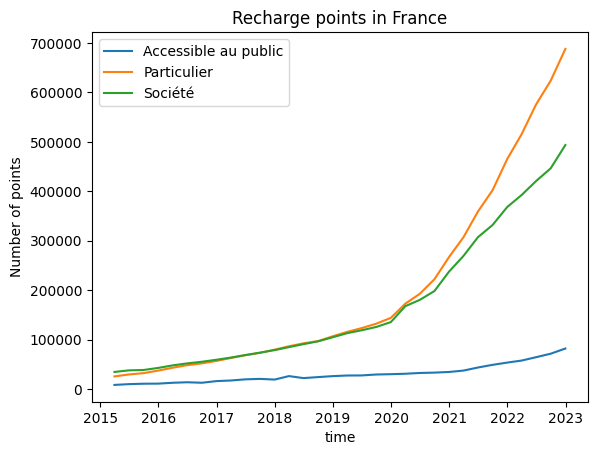

In [6]:
ax=sns.lineplot(data=irve_type, x="time", y="Accessible au public", label="Accessible au public")
sns.lineplot(data=irve_type, x="time", y="Particulier",label="Particulier")
sns.lineplot(data=irve_type, x="time", y="Société",label="Société")
ax.set(title='Recharge points in France')
ax.set_ylabel("Number of points")


In [7]:
#Analyse des valeurs manquantes du jeu de données 
irve_type.isna().any()

Trimestre               False
Accessible au public    False
Particulier             False
Société                 False
%Public                 False
%Particulier            False
%Société                False
time                    False
dtype: bool

In [8]:
#Analyse des valeurs doublons du jeu de données 
irve_type.duplicated().any()

False

## Traitement des données sur les bornes de recharge pour vehicules electriques (IRVE)


Dans le but de constituer un répertoire national des Infrastructures de recharge pour véhicules électriques (IRVE), ouvert et accessible à tous, les collectivités locales porteuses d’un projet d’installation d’IRVE doivent, au fur et à mesure de la mise en service des stations, publier sur la plateforme data.gouv.fr les données statiques relatives à la localisation et aux caractéristiques techniques de ces installations selon les modalités définies dans l’arrêté du 4 mai 2021.
Etalab consolide l'ensemble des jeux de données produits par les différents acteurs territoriaux sur un jeu de donnée consolidé. Celui-ci a pour objectif d'être le plus exhaustif possible et ambitionne de regrouper l'ensemble des bornes IRVE françaises. Un document décrivant l'ensemble des datasources utilisées pour cette consolidation peut être consulté sur la page data.gouv de la datasource.

[Datasource data.gouv](https://www.data.gouv.fr/fr/datasets/fichier-consolide-des-bornes-de-recharge-pour-vehicules-electriques/)


In [9]:
irve = pd.read_csv('raw_data/consolidation-etalab-irve.csv', sep=',', on_bad_lines='skip')
display(irve.shape)
irve

(55320, 50)

nom_amenageur  siren_amenageur              contact_amenageur  \
0                     ELECTRA      891624884.0               help@electra.com   
1                     ELECTRA      891624884.0               help@electra.com   
2                     ELECTRA      891624884.0               help@electra.com   
3                     ELECTRA      891624884.0               help@electra.com   
4                     ELECTRA      891624884.0               help@electra.com   
...                       ...              ...                            ...   
55315            EVE CAR PLUG      879689750.0         contact@evecarplug.com   
55316           MA Borne Auto      880217922.0        e.barre@maborneauto.com   
55317  Societe Ouest Location      323873174.0  Axel.peigne@ouest-location.fr   
55318  Societe Ouest Location      323873174.0  Axel.peigne@ouest-location.fr   
55319  Societe Ouest Location      323873174.0  Axel.peigne@ouest-location.fr   

       nom_operateur           contact_operateur telephone_operateur  \
0            ELECTRA            help@electra.com                 NaN   
1            ELECTRA            help@electra.com                 NaN   
2            ELECTRA            help@electra.com                 NaN   
3            ELECTRA            help@electra.com                 NaN   
4            ELECTRA            help@electra.com                 NaN   
...              ...                         ...                 ...   
55315     CHARGEPOLY     operator@chargepoly.com          0788984775   
55316  ma Borne Auto     e.barre@maborneauto.com          0361626161   
55317  Freshmile SAS  exploitation@freshmile.com           369246732   
55318  Freshmile SAS  exploitation@freshmile.com           369246732   
55319  Freshmile SAS  exploitation@freshmile.com           369246732   

      nom_enseigne              id_station_itinerance  \
0          ELECTRA                        FRELCPBLOHM   
1          ELECTRA                        FRELCPECUSM   
2          ELECTRA                        FRELCPSBARS   
3          ELECTRA                        FRELCPSBARS   
4          ELECTRA                        FRELCPSBARS   
...            ...                                ...   
55315   CHARGEPOLY  FRCHAPCL667TZRR31386098QO29VPVB0N   
55316  DACIA RONCQ                       Non concerné   
55317    Freshmile                         FRFR1EGYTZ   
55318    Freshmile                         FRFR1EGYTZ   
55319    Freshmile                         FRFR1EGYTZ   

                  id_station_local  \
0                              NaN   
1                              NaN   
2                              NaN   
3                              NaN   
4                              NaN   
...                            ...   
55315  cl667tzrr31386098qo29vpvb0n   
55316   01FHWQ8RECFE028717E5Y5123P   
55317                          NaN   
55318                          NaN   
55319                          NaN   

                                            nom_station  ...  \
0      Blotzheim - Hôtel Mercure Bâle Mulhouse Aéroport  ...   
1                            Écully - Smart Lyon Écully  ...   
2                    Saint-Barthélemy-d'Anjou - RS Parc  ...   
3                    Saint-Barthélemy-d'Anjou - RS Parc  ...   
4                    Saint-Barthélemy-d'Anjou - RS Parc  ...   
...                                                 ...  ...   
55315                                 INDIAN MOTORCYCLE  ...   
55316                                       DACIA RONCQ  ...   
55317                    Ouest Location, Saint Herblain  ...   
55318                    Ouest Location, Saint Herblain  ...   
55319                    Ouest Location, Saint Herblain  ...   

                          last_modified       datagouv_dataset_id  \
0      2023-03-28T05:05:10.757000+00:00  623ca46c13130c3228abd018   
1      2023-03-28T05:05:10.757000+00:00  623ca46c13130c3228abd018   
2      2023-03-28T05:05:10.757000+00:00  623ca46c13130c3228a

In [39]:
irve.columns

Index(['nom_amenageur', 'siren_amenageur', 'contact_amenageur',
       'nom_operateur', 'contact_operateur', 'telephone_operateur',
       'nom_enseigne', 'id_station_itinerance', 'id_station_local',
       'nom_station', 'implantation_station', 'adresse_station',
       'code_insee_commune', 'coordonneesXY', 'nbre_pdc', 'id_pdc_itinerance',
       'id_pdc_local', 'puissance_nominale', 'prise_type_ef', 'prise_type_2',
       'prise_type_combo_ccs', 'prise_type_chademo', 'prise_type_autre',
       'gratuit', 'paiement_acte', 'paiement_cb', 'paiement_autre',
       'tarification', 'condition_acces', 'reservation', 'horaires',
       'accessibilite_pmr', 'restriction_gabarit', 'station_deux_roues',
       'raccordement', 'num_pdl', 'date_mise_en_service', 'observations',
       'date_maj', 'cable_t2_attache', 'last_modified', 'datagouv_dataset_id',
       'datagouv_resource_id', 'datagouv_organization_or_owner',
       'consolidated_longitude', 'consolidated_latitude',
       'consolidate

In [10]:
list(irve.nom_amenageur.unique())

['ELECTRA',
 'ARCACHON',
 'GARENNE',
 'FLEX-E',
 'GRAND NANCY',
 'MOBIVE - SDEER 17',
 'SIGEIF',
 'MOBIVE - TE 47',
 'CPS',
 'IZIVIA EXPRESS',
 'MOBIVE - SYDEC 40',
 'AVIA TD',
 'IZIVIA FMET 1',
 'UNIBAIL',
 'LEVAPARC',
 'MOBIVE - SEHV87',
 'OUEST CHARGE - 22',
 'WIIIZ',
 'SIXT',
 'MOBIVE - FDEE 19',
 'OUEST CHARGE - 29',
 'MOBIVE - SDEG 16',
 'MOBIVE - SDEPA 64',
 'OUEST CHARGE - 35',
 'SYDER',
 'AVIA PICOTY',
 'MOBIVE - SDE 24',
 'RT78',
 'MAMP',
 'SHELL',
 'ZENPARK',
 'SDESM',
 'GRSE GARAGE MARINIERE',
 'SCEA LES FUIES ',
 'SCEA LES FUIES',
 'STARTERRE',
 "LUMI'IN",
 'Hôtel Restaurant Campanile Nogent-sur-Marne',
 'Résidence Les Calanques',
 'Hotel saint Alban',
 '1PACTE',
 'Villa Primerose',
 'MAZDA CHALON S.SAONE - GROUPE GUILLET',
 'PAROT AUTOMOTIVE - MAZDA BRIVE ',
 'Aubade - Comptoir des Fers',
 'Aubade - Comptoir des Fer',
 'SCI LE PARC MILLESIME',
 'Suraya',
 'WeeCharge',
 'GCA CAEN ',
 'GCA CAEN',
 'Green Technologie',
 'MA BORNE AUTO',
 'DPA -MAZDA MONTELIMAR',
 'AUTO SPRIN

In [11]:
irve.isna().sum()

nom_amenageur                           3144
siren_amenageur                        14488
contact_amenageur                      14705
nom_operateur                           3624
contact_operateur                          0
telephone_operateur                     6860
nom_enseigne                               0
id_station_itinerance                      0
id_station_local                       26015
nom_station                                0
implantation_station                       0
adresse_station                            0
code_insee_commune                     16140
coordonneesXY                              0
nbre_pdc                                   0
id_pdc_itinerance                          0
id_pdc_local                           25927
puissance_nominale                         0
prise_type_ef                              0
prise_type_2                               0
prise_type_combo_ccs                       0
prise_type_chademo                         0
prise_type

Le premier point de contrôle passe par la recherche d'éventuels doublons. Notons que le contexte métier nécessite de la rigueur dans l'interprétation de certaines variables, l'amalgame entre station, borne et point de charge est régulièrement rencontré. Donc, "id_station" n'est pas le sous-ensemble le plus approprié à l'identification de doublons, une station de recharge peut avoir plusieurs points de charge, et l'identifiant ne tient pas compte du point de charge. Notons que "id_pdc_itinerance" permet d'obtenir des identifiants uniques pouvant cette fois-ci être pris comme sous-ensemble.

In [12]:
columns=irve.columns
for col in columns:
    duplicate_sum=irve[col].duplicated().sum()
    print(col, duplicate_sum)

nom_amenageur 52772
siren_amenageur 54134
contact_amenageur 54767
nom_operateur 55076
contact_operateur 55038
telephone_operateur 54953
nom_enseigne 53822
id_station_itinerance 36594
id_station_local 44396
nom_station 39770
implantation_station 55315
adresse_station 38728
code_insee_commune 50101
coordonneesXY 37997
nbre_pdc 55269
id_pdc_itinerance 11731
id_pdc_local 27253
puissance_nominale 55232
prise_type_ef 55312
prise_type_2 55312
prise_type_combo_ccs 55312
prise_type_chademo 55313
prise_type_autre 55313
gratuit 55311
paiement_acte 55312
paiement_cb 55312
paiement_autre 55311
tarification 55103
condition_acces 55318
reservation 55313
horaires 54751
accessibilite_pmr 55316
restriction_gabarit 55165
station_deux_roues 55314
raccordement 55317
num_pdl 52579
date_mise_en_service 53063
observations 55170
date_maj 54672
cable_t2_attache 55312
last_modified 54523
datagouv_dataset_id 54668
datagouv_resource_id 54523
datagouv_organization_or_owner 55111
consolidated_longitude 38090
consoli

**TO DISCUSS IF USE OTHER DATA. Remarque de nalron:**

Notons que le fichier mis à disposition sur le site data.gouv.fr annonce plusieurs consolidations selon les années 2014 à 2016 et 2018. Attention, quelques opérateurs comme Tesla, Nissan, Auchan, etc… ne sont plus observés dans la version de juin 2020 et même depuis plusieurs mois. Non pas parce que ces stations de recharge ont été retirées, mais par logique d'uniformisation selon une charte d'utilisation "Fichiers à destination des aménageurs et opérateurs publics et privés d'infrastructures de recharge pour véhicules électriques" consultable sur [data.gouv.fr](https://www.data.gouv.fr/fr/datasets/fichiers-pour-les-infrastructures-de-recharge-de-vehicules-electriques/)

<em>Le décret 2017-26 du 12 janvier 2017 fixe les exigences requises pour la configuration des points de recharge à publier sur un nouveau fichier désormais en CSV. L'aménageur, ou l'opérateur désigné le cas échéant, prend les mesures appropriées pour que ces données soient en permanence tenues à jour et rendues publiques sur data.gouv.fr</em>

<u>Dans le cadre de l'étude, les opérateurs (ou principaux opérateurs) identifiés comme manquants seront réintégrés dans l'échantillon.</u>

In [13]:
#Combien de stations de recharge en Mars 2023
irve.id_station_itinerance.nunique()

18726

In [14]:
irve.id_station_local.nunique()

10923

In [15]:
#Combien de bornes de recharge (en anglais Charging Station) en Mars 2023
irve.id_pdc_itinerance.nunique()

43589

**Combien de points de charge en France?**
Selon la définition de l'AFIREV, le point de charge représente le nombre d'emplacements individuels permettant le stationnement du véhicule pendant le temps de charge, donc le nombre de prises de la borne. Le jeu de données `irve` ne permet pas de le quantifier directement, malgré la présence d'une variable 'nbre_pdc' qui ne représente que la borne et non le nombre de prises. Il est nécessaire d'enrichir les données par une estimation des prises de chacune des bornes, ce calcul pourra être réalisé à l'aide de la variable 'type_prise'. <u>Cet enrichissement sera fait plus tard après intégration des opérateurs manquants.</u>

Les articles suivants permettent de se faire une idée de l'évolution du nombre de points de charge en France en 2022 et 2023 : 

**Article de Février 2023:** [Source](https://www.tressol-chabrier.com/actualites/Le+futur+de+l%E2%80%99automobile/Voiture%2B%25C3%25A9lectrique%2B%253A%2B85%2B284%2Bpoints%2Bde%2Brecharge%2Bdisponibles%2Ben%2BFrance-107) 

"85 284, c’est le nombre de points de recharge ouverts au public au 31 janvier 2023. Il est donc aujourd’hui de plus en plus facile de recharger sa voiture électrique. Il s’agit d’une évolution de + 57 % en un an. Si ces efforts se poursuivent, l’objectif pour la France d’atteindre les 100 000 points de recharge est ainsi facilement atteignable."


**Article de Avril 2022:** [Source](https://www.lesnumeriques.com/voiture/le-chiffre-du-jour-57-732-bornes-de-recharge-pour-voitures-electriques-en-france-n180505.html) 

"Il indique que la France peut désormais compter sur 57 732 points de recharge ouverts au public au 31 mars 2022. L'Avere France se satisfait d'un taux d'évolution de 54 % sur 12 mois"

#### Traitement NaN des variables n_amenageur, n_operateur et n_enseigne

In [16]:
#Traitement des NaN relatifs aux aménageurs selon l'enseigne
irve[irve['nom_amenageur'].isna()]['nom_enseigne'].unique()

array(['Ubitricity France Network', 'Hostellerie aux deux cléfs',
       'AREA Tech', 'ChargePoint', 'Camping la Belle Etoile',
       "MOULINS D'ASCQ", 'CLUB MED', 'GALILEO', 'MINI Panel Melun',
       'BMW Colmar', 'MINI Panel Auxerre', 'BMW MINI Panel Sens',
       'BMW REZÉ - Pays de Loire Automobiles',
       'BMW NANTES - Pays de Loire Automobiles',
       'Bmw Mini Saint-Herblain', 'Neviere',
       'Hyundai Valence - Valence Motors', 'FabreVolvo12850*1',
       'Bonne Anse Plage - Camping Siblu', 'DAF - GSVI MARSEILLE',
       'concessionnaire TOYOTA / NISSAN', 'Concessionnaire Kia',
       'HotelAKENA44000*1', 'Kia - MOTORS 76 Dieppe',
       'Hyundai Bruay-La-Buissière - Groupe Lempereur',
       'Concessionnaire Hyundai Sens', 'concessionnaire VOLVO',
       'Station Eurotyre', 'Camping 3 étoiles',
       'Volkswagen Véhicules Utilitaires', 'PANEL FONTAINEBLEAU Mini',
       'Volvo Tours (37) - Val de Loire Automobile',
       "Hyundai Lille Villeneuve-d'Ascq - V2 Automobile

In [17]:
irve.loc[irve['nom_enseigne'].str.contains('BMW'),'nom_amenageur']='BMW'

irve[irve['nom_enseigne'].str.contains('BMW')]

nom_amenageur  siren_amenageur                       contact_amenageur  \
6348            BMW      348714403.0  hugo.lebreton@envergureauto.net.bmw.fr   
6352            BMW      330117821.0                   l.leleu@groupegca.com   
6996            BMW      394452973.0                 h.gilloux@groupegca.com   
7018            BMW      394452973.0               t.kolifrath@groupegca.com   
7567            BMW      348714403.0  joachim.marie@envergureauto.net.bmw.fr   
...             ...              ...                                     ...   
51889           BMW      851779066.0             bruno.cavagni@caravenue.com   
51890           BMW      332834175.0             bruno.cavagni@caravenue.com   
51891           BMW      332834175.0             bruno.cavagni@caravenue.com   
51892           BMW      332834175.0             bruno.cavagni@caravenue.com   
51893           BMW      332834175.0             bruno.cavagni@caravenue.com   

                        nom_operateur  \
6348                        Freshmile   
6352                        Freshmile   
6996                        Freshmile   
7018                        Freshmile   
7567                        Freshmile   
...                               ...   
51889  TotalEnergies Marketing France   
51890  TotalEnergies Marketing France   
51891  TotalEnergies Marketing France   
51892  TotalEnergies Marketing France   
51893  TotalEnergies Marketing France   

                             contact_operateur telephone_operateur  \
6348                exploitation@freshmile.com          0388257058   
6352                exploitation@freshmile.com          0388257058   
6996                exploitation@freshmile.com          0388257058   
7018                exploitation@freshmile.com          0388257058   
7567                exploitation@freshmile.com          0388257058   
...                                        ...                 ...   
51889  supervision-ev.france@totalenergies.com          0483568009   
51890  supervision-ev.france@totalenergies.com          0483568009   
51891  supervision-ev.france@totalenergies.com          0483568009   
51892  supervision-ev.france@totalenergies.com          0483568009   
51893  supervision-ev.france@totalenergies.com          0483568009   

         nom_enseigne id_station_itinerance id_station_local  \
6348              BMW           FRFR1EDWYQ1      FRFR1EDWYQ1   
6352              BMW           FRFR1EATXX1      FRFR1EATXX1   
6996              BMW           FRFR1EWRWA1      FRFR1EWRWA1   
7018              BMW           FRFR1EMWPZ1      FRFR1EMWPZ1   
7567              BMW           FRFR1EAGUA1      FRFR1EAGUA1   
...               ...                   ...              ...   
51889  BMW SARREBOURG           FRTCBP00698      FRTCBP00698   
51890        BMW METZ           FRTCBP00697      FRTCBP00697   
51891        BMW METZ           FRTCBP00697      FRTCBP00697   
51892        BMW METZ           FRTCBP00697      FRTCBP00697   
51893        BMW METZ           FRTCBP00697      FRTCBP00697   

                       nom_station  ...                     last_modified  \
6348                 BMW GRANVILLE  ...  2023-03-27T10:05:56.006000+00:00   
6352          BMW MAREIL LES MEAUX  ...  2023-03-27T10:05:55.038000+00:00   
6996      BMW CHARLEVILLE MEZIERES  ...  2023-03-27T10:05:28.679000+00:00   
7018      BPW CHALONS EN CHAMPAGNE  ...  2023-03-27T10:05:24.422000+00:00   
7567                  BMW SAINT LO  ...  2023-03-27T10:04:43.045000+00:00   
...                            ...  ...                               ...   
51889  CAR AVENUE - BMW SARREBOURG  ...  2023-03-27T09:59:52.744000+00:00   
51890        CAR AVENUE - BMW METZ  ...  2023-03-27T09:59:52.744000+00:00   
51891        CAR AVENUE - BMW METZ  ...  2023-03-27T09:59:52.744000+00:00   
51892        CAR AVENUE - BMW METZ  ...  2023-03-27T09:59:52.744000+00:00   
51893        CAR AVENUE - BMW METZ  ...  2023-03-27T09:59:52.744000+00:00   

            datag

In [18]:
irve.loc[irve['nom_enseigne'].str.contains('NISSAN'),'nom_amenageur']='NISSAN'

irve[irve['nom_enseigne'].str.contains('NISSAN')]

nom_amenageur  siren_amenageur         contact_amenageur nom_operateur  \
37752        NISSAN      397658931.0  exploitation@driveco.com           NaN   
37768        NISSAN      397658931.0  exploitation@driveco.com           NaN   
37769        NISSAN      397658931.0  exploitation@driveco.com           NaN   
37770        NISSAN      397658931.0  exploitation@driveco.com           NaN   
37771        NISSAN      397658931.0  exploitation@driveco.com           NaN   
37786        NISSAN      397658931.0  exploitation@driveco.com           NaN   
38177        NISSAN      801121096.0  exploitation@driveco.com           NaN   
38184        NISSAN      801121096.0  exploitation@driveco.com           NaN   
38185        NISSAN      801121096.0  exploitation@driveco.com           NaN   
38187        NISSAN      801121096.0  exploitation@driveco.com           NaN   

              contact_operateur telephone_operateur  \
37752  exploitation@driveco.com                 NaN   
37768  exploitation@driveco.com                 NaN   
37769  exploitation@driveco.com                 NaN   
37770  exploitation@driveco.com                 NaN   
37771  exploitation@driveco.com                 NaN   
37786  exploitation@driveco.com                 NaN   
38177  exploitation@driveco.com                 NaN   
38184  exploitation@driveco.com                 NaN   
38185  exploitation@driveco.com                 NaN   
38187  exploitation@driveco.com                 NaN   

                          nom_enseigne     id_station_itinerance  \
37752  concessionnaire TOYOTA / NISSAN  FRSSDPMAURINTOYOTA843001   
37768  concessionnaire TOYOTA / NISSAN  FRSSDPMAURINTOYOTA843001   
37769  concessionnaire TOYOTA / NISSAN  FRSSDPMAURINTOYOTA843001   
37770  concessionnaire TOYOTA / NISSAN  FRSSDPMAURINTOYOTA843001   
37771  concessionnaire TOYOTA / NISSAN  FRSSDPMAURINTOYOTA843001   
37786  concessionnaire TOYOTA / NISSAN  FRSSDPMAURINTOYOTA843001   
38177                  EDENAUTO NISSAN    FRSSDPEDENAUTOMG641401   
38184                  EDENAUTO NISSAN    FRSSDPEDENAUTOMG641401   
38185                  EDENAUTO NISSAN  FRSSDPEDENAUTOSEAT641401   
38187                  EDENAUTO NISSAN  FRSSDPEDENAUTOSEAT641401   

      id_station_local                nom_station  ...  \
37752              NaN  Toyota - Nissan Cavaillon  ...   
37768              NaN  Toyota - Nissan Cavaillon  ...   
37769              NaN  Toyota - Nissan Cavaillon  ...   
37770              NaN  Toyota - Nissan Cavaillon  ...   
37771              NaN  Toyota - Nissan Cavaillon  ...   
37786              NaN  Toyota - Nissan Cavaillon  ...   
38177              NaN                    MG Lons  ...   
38184              NaN                    MG Lons  ...   
38185              NaN                  Seat Lons  ...   
38187              NaN                  Seat Lons  ...   

                          last_modified       datagouv_dataset_id  \
37752  2023-03-27T10:00:53.348000+00:00  5fd093b73438a6a99bdf3606   
37768  2023-03-27T10:00:53.348000+00:00  5fd093b73438a6a99bdf3606   
37769  2023-03-27T10:00:53.348000+00:00  5fd093b73438a6a99bdf3606   
37770  2023-03-27T10:00:53.348000+00:00  5fd093b73438a6a99bdf3606   
37771  2023-03-27T10:00:53.348000+00:00  5fd093b73438a6a99bdf3606   
37786  2023-03-27T10:00:53.348000+00:00  5fd093b73438a6a99bdf3606   
38177  2023-03-27T10:00:53.348000+00:00  5fd093b73438a6a99bdf3606   
38184  2023-03-27T10:00:53.348000+00:00  5fd093b73438a6a99bdf3606   
38185  2023-03-27T10:00:53.348000+00:00  5fd093b73438a6a99bdf3606   
38187  2023-03-27T10:00:53.348000+00:00  5fd093b73438a6a99bdf3606   

                       datagouv_resource_id datagouv_organization_or_owner  \
37752  86f67515-fce9-4768-ae09-d49b21467bee                        driveco   
37768  86f67515-fce9-4768-ae09-d49b21467bee                        driveco   
37769  86f67515-fce9-4768-ae09-d49b21467bee                        driveco   
37770  86f67515-fce9-4768-ae09-d49b21467bee                

In [19]:
irve.loc[irve['nom_enseigne']=='Renault','nom_amenageur']='RENAULT'
irve[irve['nom_enseigne']=='Renault']

nom_amenageur  siren_amenageur         contact_amenageur nom_operateur  \
39473       RENAULT      788735629.0  exploitation@driveco.com           NaN   
39474       RENAULT      788735629.0  exploitation@driveco.com           NaN   
39485       RENAULT      788735629.0  exploitation@driveco.com           NaN   
39486       RENAULT      788735629.0  exploitation@driveco.com           NaN   
39506       RENAULT      431970912.0  exploitation@driveco.com           NaN   
39507       RENAULT      431970912.0  exploitation@driveco.com           NaN   
39515       RENAULT      311157762.0  exploitation@driveco.com           NaN   
39525       RENAULT      311157762.0  exploitation@driveco.com           NaN   
40224       RENAULT      304455298.0  exploitation@driveco.com           NaN   
40225       RENAULT      304455298.0  exploitation@driveco.com           NaN   

              contact_operateur telephone_operateur nom_enseigne  \
39473  exploitation@driveco.com                 NaN      Renault   
39474  exploitation@driveco.com                 NaN      Renault   
39485  exploitation@driveco.com                 NaN      Renault   
39486  exploitation@driveco.com                 NaN      Renault   
39506  exploitation@driveco.com                 NaN      Renault   
39507  exploitation@driveco.com                 NaN      Renault   
39515  exploitation@driveco.com                 NaN      Renault   
39525  exploitation@driveco.com                 NaN      Renault   
40224  exploitation@driveco.com                 NaN      Renault   
40225  exploitation@driveco.com                 NaN      Renault   

                id_station_itinerance id_station_local  \
39473       FRSSDPMAURINRENAULT944701              NaN   
39474       FRSSDPMAURINRENAULT944701              NaN   
39485       FRSSDPMAURINRENAULT944501              NaN   
39486       FRSSDPMAURINRENAULT944501              NaN   
39506      FRSSDPBYMYCARRENAULT386001              NaN   
39507      FRSSDPBYMYCARRENAULT386001              NaN   
39515     FRSSDPEMILFREYRENAULT628001              NaN   
39525     FRSSDPEMILFREYRENAULT628001              NaN   
40224  FRSSDPAUTOBERNARDRENAULT382001              NaN   
40225  FRSSDPAUTOBERNARDRENAULT382001              NaN   

                        nom_station  ...                     last_modified  \
39473       Renault Boissy-St-Léger  ...  2023-03-27T10:00:53.348000+00:00   
39474       Renault Boissy-St-Léger  ...  2023-03-27T10:00:53.348000+00:00   
39485                Renault Limeil  ...  2023-03-27T10:00:53.348000+00:00   
39486                Renault Limeil  ...  2023-03-27T10:00:53.348000+00:00   
39506      ByMyCar Renault Fontaine  ...  2023-03-27T10:00:53.348000+00:00   
39507      ByMyCar Renault Fontaine  ...  2023-03-27T10:00:53.348000+00:00   
39515                Renault Liévin  ...  2023-03-27T10:00:53.348000+00:00   
39525                Renault Liévin  ...  2023-03-27T10:00:53.348000+00:00   
40224  Autobernard - Renault Vienne  ...  2023-03-27T10:00:53.348000+00:00   
40225  Autobernard - Renault Vienne  ...  2023-03-27T10:00:53.348000+00:00   

            datagouv_dataset_id                  datagouv_resource_id  \
39473  5fd093b73438a6a99bdf3606  86f67515-fce9-4768-ae09-d49b21467bee   
39474  5fd093b73438a6a99bdf3606  86f67515-fce9-4768-ae09-d49b21467bee   
39485  5fd093b73438a6a99bdf3606  86f67515-fce9-4768-ae09-d49b21467bee   
39486  5fd093b73438a6a99bdf3606  86f67515-fce9-4768-ae09-d49b21467bee   
39506  5fd093b73438a6a99bdf3606  86f67515-fce9-4768-ae09-d49b21467bee   
39507  5fd093b73438a6a99bdf3606  86f67515-fce9-4768-ae09-d49b21467bee   
39515  5fd093b73438a6a99bdf3606  86f67515-fce9-4768-ae09-d49b21467bee   
39525  5fd093b73438a6a99bdf3606  86f67515-fce9-4768-ae09-d49b21467bee   
40224  5fd093b73438a6a99bdf3606  86f67515-fce9-4768-ae09-d49b21467bee   
40225  5fd093b73438a6a99bdf3606  86f67515-fce9-4768-ae09-d49b21467bee   

      datagouv_organization_or_owner  consolidated_longitude  \
39473     

In [20]:
irve.loc[irve['nom_enseigne'].str.lower().str.contains('leclerc'),'nom_amenageur']='LECLERC'
irve[irve['nom_enseigne'].str.lower().str.contains('leclerc')]

nom_amenageur  siren_amenageur                contact_amenageur  \
14638       LECLERC      341760148.0  thomas.millerand@millau.leclerc   
37572       LECLERC      394121545.0               sylvie.at@scaso.fr   
37573       LECLERC      394121545.0               sylvie.at@scaso.fr   
37574       LECLERC      394121545.0               sylvie.at@scaso.fr   
37575       LECLERC      394121545.0               sylvie.at@scaso.fr   
37576       LECLERC      394121545.0        ingrid.labarrere@scaso.fr   
37577       LECLERC      394121545.0        ingrid.labarrere@scaso.fr   
37578       LECLERC      394121545.0        ingrid.labarrere@scaso.fr   
37579       LECLERC      394121545.0        ingrid.labarrere@scaso.fr   
37580       LECLERC      394121545.0        ingrid.labarrere@scaso.fr   
37581       LECLERC      394121545.0        ingrid.labarrere@scaso.fr   
37582       LECLERC      394121545.0        ingrid.labarrere@scaso.fr   
37583       LECLERC      394121545.0        ingrid.labarrere@scaso.fr   
37584       LECLERC      390923175.0           franck.pothin@scaso.fr   
37585       LECLERC      390923175.0           franck.pothin@scaso.fr   
37586       LECLERC      341055705.0          stephane.henry@scaso.fr   
37587       LECLERC      341055705.0          stephane.henry@scaso.fr   
37588       LECLERC      341055705.0          stephane.henry@scaso.fr   
37589       LECLERC      341055705.0          stephane.henry@scaso.fr   
37590       LECLERC      810800268.0          lucas.ribelles@scaso.fr   
37591       LECLERC      810800268.0          lucas.ribelles@scaso.fr   
39475       LECLERC      451282701.0         exploitation@driveco.com   
39476       LECLERC      451282701.0         exploitation@driveco.com   
39477       LECLERC      451282701.0         exploitation@driveco.com   
39478       LECLERC      451282701.0         exploitation@driveco.com   
39479       LECLERC      451282701.0         exploitation@driveco.com   
39480       LECLERC      451282701.0         exploitation@driveco.com   
45808       LECLERC      716980297.0      juridique.socadi@scapest.fr   
45833       LECLERC      310162417.0      elodie.princet@scalandes.fr   
45843       LECLERC      510125842.0           donato.zuddas@scaso.fr   
45910       LECLERC      513254920.0   directeur.barroidis@scapest.fr   

              nom_operateur                contact_operateur  \
14638        Leclerc Millau  thomas.millerand@millau.leclerc   
37572  PLAGECO DISTRIBUTION               sylvie.at@scaso.fr   
37573  PLAGECO DISTRIBUTION               sylvie.at@scaso.fr   
37574  PLAGECO DISTRIBUTION               sylvie.at@scaso.fr   
37575  PLAGECO DISTRIBUTION               sylvie.at@scaso.fr   
37576  PLAGECO DISTRIBUTION               sylvie.at@scaso.fr   
37577  PLAGECO DISTRIBUTION               sylvie.at@scaso.fr   
37578  PLAGECO DISTRIBUTION               sylvie.at@scaso.fr   
37579  PLAGECO DISTRIBUTION               sylvie.at@scaso.fr   
37580  PLAGECO DISTRIBUTION               sylvie.at@scaso.fr   
37581  PLAGECO DISTRIBUTION               sylvie.at@scaso.fr   
37582  PLAGECO DISTRIBUTION               sylvie.at@scaso.fr   
37583  PLAGECO DISTRIBUTION               sylvie.at@scaso.fr   
37584   LANGON DISTRIBUTION           franck.pothin@scaso.fr   
37585   LANGON DISTRIBUTION           franck.pothin@scaso.fr   
37586    BIARS DISTRIBUTION          stephane.henry@scaso.fr   
37587    BIARS DISTRIBUTION          stephane.henry@scaso.fr   
37588    BIARS DISTRIBUTION          stephane.henry@scaso.fr   
37589    BIARS DISTRIBUTION          stephane.henry@scaso.fr   
37590            SAS Miodis          lucas.ribelles@scaso.fr   
37591            SAS Miodis          lucas.ribelles@scaso.fr   
39475                   NaN         exploitation@driveco.com   
39476                   NaN         exploitation@driveco.com   
39477                   NaN         exploitation@driveco.com   
39478                   NaN         exploitation@driveco.com   
39479

In [21]:
# Bilan
display(len(irve[irve['nom_amenageur'].isna()]['nom_enseigne'].unique()))
irve[irve['nom_amenageur'].isna()]['nom_enseigne'].unique()

382

array(['Ubitricity France Network', 'Hostellerie aux deux cléfs',
       'AREA Tech', 'ChargePoint', 'Camping la Belle Etoile',
       "MOULINS D'ASCQ", 'CLUB MED', 'GALILEO', 'MINI Panel Melun',
       'MINI Panel Auxerre', 'Bmw Mini Saint-Herblain', 'Neviere',
       'Hyundai Valence - Valence Motors', 'FabreVolvo12850*1',
       'Bonne Anse Plage - Camping Siblu', 'DAF - GSVI MARSEILLE',
       'Concessionnaire Kia', 'HotelAKENA44000*1',
       'Kia - MOTORS 76 Dieppe',
       'Hyundai Bruay-La-Buissière - Groupe Lempereur',
       'Concessionnaire Hyundai Sens', 'concessionnaire VOLVO',
       'Station Eurotyre', 'Camping 3 étoiles',
       'Volkswagen Véhicules Utilitaires', 'PANEL FONTAINEBLEAU Mini',
       'Volvo Tours (37) - Val de Loire Automobile',
       "Hyundai Lille Villeneuve-d'Ascq - V2 Automobiles", 'KIA - Nîmes',
       'VAL DE LOIRE AUTOMOBILES SAUMUR', 'Hyundai Manosque - Pedinielli',
       'Spie Batignolles Petavit', 'HYUNDAI ARRAS - AUTOLEADER',
       'Volvo - 

In [22]:
#Traitement des NaN relatifs aux opérateurs selon l'aménageur
irve[irve['nom_operateur'].isna()]['nom_amenageur'].unique()

array(['GRAND NANCY', 'MOBIVE - SDEER 17', 'SIGEIF', 'MOBIVE - TE 47',
       'CPS', 'IZIVIA EXPRESS', 'MOBIVE - SYDEC 40', 'IZIVIA FMET 1',
       'UNIBAIL', 'MOBIVE - SEHV87', 'OUEST CHARGE - 22', 'WIIIZ',
       'MOBIVE - FDEE 19', 'OUEST CHARGE - 29', 'OUEST CHARGE - 35',
       'SYDER', 'ZENPARK', 'GRSE GARAGE MARINIERE', 'Indigo Propreté',
       'MOMATECH SARL - TECHOFFICE', 'BOIS CHERI - HOTEL DU PORGE',
       'HAPOGYS', 'LE  MOULIN DE LABOIRIE',
       "L'Hotelloise Hotel des Bains", 'ROBOTIC COVER CONCEPT', 'EPGML',
       'UCPA BOMBANNES', 'MOBIVE LA DIEGE', 'SEGA ELECTRICITE',
       'SCACHE GARAGE SENIA', nan, 'DE LEPERVANCHE Céline', 'TENTE SAS',
       'OVERCHEM', 'PHA', 'GAMBUS SARL', 'SERNAD INVESTISSEMENT',
       'METALLERIE PERRUT', 'BMW', 'NISSAN', 'RENAULT', 'LECLERC',
       'MANUBOB', 'FLYOPS', 'NOVABIO', 'SARL RUITER', 'GAZ DE BORDEAUX',
       '4M RETAIL', "L'AERODROME DE LA BAIE DE SOMME",
       'MOBIVE - SDEEG 33'], dtype=object)

In [23]:
irve[irve['consolidated_latitude'].isna()]

Empty DataFrame
Columns: [nom_amenageur, siren_amenageur, contact_amenageur, nom_operateur, contact_operateur, telephone_operateur, nom_enseigne, id_station_itinerance, id_station_local, nom_station, implantation_station, adresse_station, code_insee_commune, coordonneesXY, nbre_pdc, id_pdc_itinerance, id_pdc_local, puissance_nominale, prise_type_ef, prise_type_2, prise_type_combo_ccs, prise_type_chademo, prise_type_autre, gratuit, paiement_acte, paiement_cb, paiement_autre, tarification, condition_acces, reservation, horaires, accessibilite_pmr, restriction_gabarit, station_deux_roues, raccordement, num_pdl, date_mise_en_service, observations, date_maj, cable_t2_attache, last_modified, datagouv_dataset_id, datagouv_resource_id, datagouv_organization_or_owner, consolidated_longitude, consolidated_latitude, consolidated_code_postal, consolidated_commune, consolidated_is_lon_lat_correct, consolidated_is_code_insee_verified]
Index: []

[0 rows x 50 columns]

In [24]:
irve.isna().sum()

nom_amenageur                           2734
siren_amenageur                        14488
contact_amenageur                      14705
nom_operateur                           3624
contact_operateur                          0
telephone_operateur                     6860
nom_enseigne                               0
id_station_itinerance                      0
id_station_local                       26015
nom_station                                0
implantation_station                       0
adresse_station                            0
code_insee_commune                     16140
coordonneesXY                              0
nbre_pdc                                   0
id_pdc_itinerance                          0
id_pdc_local                           25927
puissance_nominale                         0
prise_type_ef                              0
prise_type_2                               0
prise_type_combo_ccs                       0
prise_type_chademo                         0
prise_type

**Nous avons remplacé 400 valeurs NaN dans la variable nom_amenageur.** De nombreux noms d'enseignes sont de petites enseignes voir des entreprises qui ne font pas partie d'un groupe. Il est difficile d'aller imputer un aménageur pour ces lignes là.

#### Traitement de la variable 'type_prise'

In [25]:
prises=["prise_type_ef","prise_type_2","prise_type_combo_ccs","prise_type_chademo","prise_type_autre"]
for prise in prises:
    print(irve[prise].isna().sum())
    print(prise, irve[prise].unique())

0
prise_type_ef ['false' 'true' '0' 'FALSE' 'TRUE' '1' 'True' 'False']
0
prise_type_2 ['false' 'true' '1' '0' 'TRUE' 'FALSE' 'True' 'False']
0
prise_type_combo_ccs ['true' 'false' '1' 'FALSE' '0' 'TRUE' 'False' 'True']
0
prise_type_chademo ['false' 'true' '0' 'FALSE' 'TRUE' 'False' 'True']
0
prise_type_autre ['false' 'true' '0' 'FALSE' 'TRUE' 'False' 'True']


In [26]:
#creation of column type_prise

irve.loc[irve["prise_type_ef"].str.lower()=="true","prise_type_ef"]=1
irve.loc[irve["prise_type_ef"].str.lower()=="false","prise_type_ef"]=0
irve.loc[irve["prise_type_2"].str.lower()=="true","prise_type_2"]=1
irve.loc[irve["prise_type_2"].str.lower()=="false","prise_type_2"]=0
irve.loc[irve["prise_type_combo_ccs"].str.lower()=="true","prise_type_combo_ccs"]=1
irve.loc[irve["prise_type_combo_ccs"].str.lower()=="false","prise_type_combo_ccs"]=0
irve.loc[irve["prise_type_autre"].str.lower()=="true","prise_type_autre"]=1
irve.loc[irve["prise_type_autre"].str.lower()=="false","prise_type_autre"]=0
irve.loc[irve["prise_type_chademo"].str.lower()=="true","prise_type_chademo"]=1
irve.loc[irve["prise_type_chademo"].str.lower()=="false","prise_type_chademo"]=0

irve["prise_type_ef"]=irve["prise_type_ef"].astype(int)
irve["prise_type_2"]=irve["prise_type_2"].astype(int)
irve["prise_type_combo_ccs"]=irve["prise_type_combo_ccs"].astype(int)
irve["prise_type_autre"]=irve["prise_type_autre"].astype(int)
irve["prise_type_chademo"]=irve["prise_type_chademo"].astype(int)

In [27]:
prises=["prise_type_ef","prise_type_2","prise_type_combo_ccs","prise_type_chademo","prise_type_autre"]
for prise in prises:
    print(prise, irve[prise].unique())

prise_type_ef [0 1]
prise_type_2 [0 1]
prise_type_combo_ccs [1 0]
prise_type_chademo [0 1]
prise_type_autre [0 1]


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'prise_type_ef'),
  Text(1, 0, 'prise_type_2'),
  Text(2, 0, 'prise_type_combo_ccs'),
  Text(3, 0, 'prise_type_chademo'),
  Text(4, 0, 'prise_type_autre')])

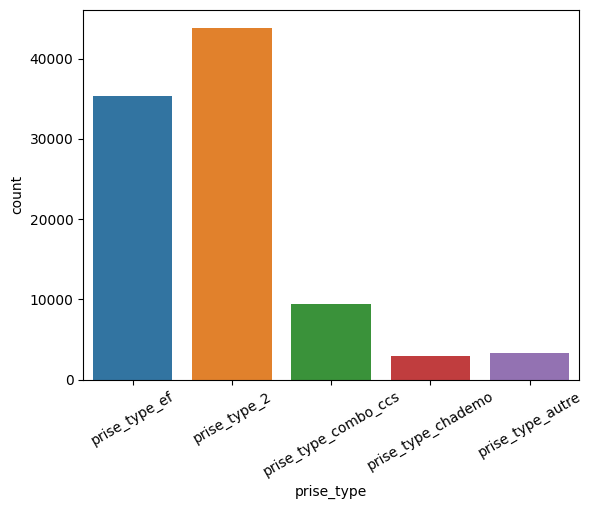

In [28]:
#test1=pd.DataFrame([irve["prise_type_ef"].sum()], columns=["bo"])
prises_list=[["prise_type_ef",irve["prise_type_ef"].sum()],["prise_type_2",irve["prise_type_2"].sum()],["prise_type_combo_ccs",irve["prise_type_combo_ccs"].sum()],["prise_type_chademo",irve["prise_type_chademo"].sum()],["prise_type_autre",irve["prise_type_autre"].sum()]]
prises_df_count=pd.DataFrame(prises_list, columns=["prise_type","count"])
sns.barplot(data=prises_df_count, x="prise_type", y="count", label=True)
prises_df_count
plt.xticks(rotation=30)

## Enrichissement de l'échantillon : catégorisation des aménageurs.

Cette étape permettra de pouvoir obtenir une vision plus explicite de qui sont les aménageurs IRVE sur notre territoire. 

In [29]:
#Aperçu de la diversité des aménageurs à l'origine de l'implantation des bornes en France
irve.nom_amenageur.unique()[:30]

array(['ELECTRA', 'ARCACHON', 'GARENNE', 'FLEX-E', 'GRAND NANCY',
       'MOBIVE - SDEER 17', 'SIGEIF', 'MOBIVE - TE 47', 'CPS',
       'IZIVIA EXPRESS', 'MOBIVE - SYDEC 40', 'AVIA TD', 'IZIVIA FMET 1',
       'UNIBAIL', 'LEVAPARC', 'MOBIVE - SEHV87', 'OUEST CHARGE - 22',
       'WIIIZ', 'SIXT', 'MOBIVE - FDEE 19', 'OUEST CHARGE - 29',
       'MOBIVE - SDEG 16', 'MOBIVE - SDEPA 64', 'OUEST CHARGE - 35',
       'SYDER', 'AVIA PICOTY', 'MOBIVE - SDE 24', 'RT78', 'MAMP', 'SHELL'],
      dtype=object)

In [30]:
#Liste des catégories pouvant rassembler les aménageurs identifiées dans l'échantillon

#Collectivités territoriales
list_c_t = ['Aix-Marseille-Provence', 'BREST METROPOLE', 'CAPG', 'CAPL', 'CARF', 'CC VITRY CHAMPAGNE ET DER', 
 'CC de la Côtičre', 'CCPA', 'CCPHVA', 'CCVBA', 'CELLIEU', 'CGLE', 'CHARLIEU','CHAUSSON MATERIAUX', 
 'CHAZELLES SUR LYON', 'CNR', 'COMMELLE VERNAY',"Communauté Urbaine d'Arras", 'CANTAL', 'Aéroports de Paris SA', 
 "Communauté d'Agglomération Douaisis Agglo","Communauté d'Agglomération Maubeuge Val de Sambre", 'SODETREL ',
 "Communauté d'Agglomération Valenciennes Métropole", "Communauté d'Agglomération du Boulonnais", 'SMOYS', 
 "Communauté d'Agglomération du Pays de Saint Omer", 'Communauté de Communes Flandre-Lys', 'SMEG 30', 
 'Communauté de Communes de la Haute Vallée de Chevreuse', "Communauté de Communes du Coeur d'Ostrevent",
 'Communauté de Communes du Haut-Pays Montreuillois', "Communauté de Communes du Pays d'Opale",
 'Communauté de Communes du Pays de Lumbres', "Commune d'Eguisheim",'FDEL 46', 'FDEL 46', 'FEURS',
 'FONTANÈS', 'FRAISSES', 'GENILAC', 'GOLF CLUB DE LYON', 'GPSO-MEUDON', 'Grenoble-Alpes Métropole', 
 'Hauts-de-France', 'Herault Energies 34', 'ISTRES', "L'ETRAT", "L'HORME", 'LA FOUILLOUSE', 'LA GRAND CROIX', 
 'LA PACAUDIÈRE', 'LA RICAMARIE', 'LA TALAUDIÈRE', 'LA VALLA EN GIER', 'LE COTEAU', 'LORETTE','Le Pont du Gard', 
 'MABLY', 'MARLHES', 'MONTAGNY', 'MONTBRISON', 'MOUVELECVAR', 'MRN', 'Modulo (Mobilité Locale Durable)',
 'Montpellier Mediterranee Metropole', 'Métropole Européenne de Lille', 'NEULISE', 'ORLEANS METROPOLE',
 'PANISSIERES', 'PARIGNY', 'PERREUX','REGNY', 'RENAISON', 'RIORGES', 'ROANNE', 'ROCHE LA MOLIÈRE',
 'SABLE SUR SARTHE', "SAINT ANDRÉ D'APCHON", 'SAINT ANDRÉ LE PUY', 'SAINT BONNET LE CHÂTEAU', 
 'SAINT CHRISTO EN JAREZ', 'SAINT CYR', 'SAINT ETIENNE ROCHETAILLÉE', 'SAINT ETIENNE SAINT VICTOR SUR LOIRE', 
 'SAINT GALMIER', 'SAINT GENEST LERPT', 'SAINT HÉAND', 'SAINT JUST SAINT RAMBERT', 'SAINT LÉGER SUR ROANNE', 
 'SAINT MARCELLIN EN FOREZ', 'SAINT MARTIN LA PLAINE', 'SAINT MAURICE EN GOURGOIS', 'SAINT PAUL EN JAREZ', 
 'SAINT ROMAIN EN JAREZ', 'SAINT ROMAIN LES ATHEUX', 'SAINT SAUVEUR EN RUE', 'SAINT SYMPHORIEN DE LAY', 'SAINT-LOUIS', 'SAINTE CROIX EN JAREZ', 
 'SALVIZINET', 'SAVIGNEUX', 'SDE 18', 'SDE 23', 'SDE 56', 'SDE 65', 'SDE07', 'SDE09', 'SDE29', 'SDE65', 'SDE76', 
 'SDEA10', 'SDED', 'SDEE48 48', 'SDESM', 'SDET 81', 'SDEY', "SDEY Syndicat Departemental d'Energies de l'Yonne", 
 'SE60', 'SEDI', 'SIDELC', 'SIED70', 'SIEDA 12', 'SIEEEN', 'SIEGE 27', 'SIEIL37', 'SIEML 49', 'SIPPEREC', 
 'SMA PNR Gatinais', 'SMED 13', 'SORBIERS', 'SOREGIES', 'SURY LE COMTAL', 'SYADEN 11', 'SYANE', 'SYDED', 
 'SYDEEL66 66', 'SYDESL', 'SYDEV 85', 'SYME05', 'Se 61', 'TE 53', "TERRITOIRE D'ENERGIE 90", 'Séolis', 'S‚olis',
 "Syndicat Départemental d'Énergie de Loire-Atlantique (SYDELA)", 'FDEE 19', 'SDEPA 64', 'SDEG 16', 
 "Syndicat Départemental d'Énergies d'Eure et Loir (SDE28)", 'SDEE 47', 'SDEER 17', 'SYDEC 40',
 "Syndicat Intercommunal de Distribution d'Electricité de Loir-et-Cher (SIDELC41)", 'SDE 24', 'SDEEG 33',
 "Syndicat de l'Énergie de l'Orne (TE61)", 'Toulouse Metropole', 'UNIEUX', 'USEDA', 'USSON EN FOREZ',
 'VEAUCHE', 'VILLARS', 'VILLE DE CAVAILLON', 'VILLE DE GAP', 'VILLE DE ROSHEIM', 'VILLEREST', "Ville d'Hazebrouck",
 'Ville de Garches', 'Ville de Montrouge', 'Ville de Revel', 'Ville de Saverne', 'Ville de Viriat', 
 'Arcs 1950 Le Village - Parking', 'B&B Hôtel Lyon Eurexpo Chassieu', "Bastide Selva - Maison d'Hôtes",
 'Baumanière les Baux de Provence', 'Belle Isle sur Risle','Benvengudo Hôtel Restaurant', 
 'Best Western Amarys Rambouillet', 'Best Western Golf Hôtel Lacanau','Best Western Grand Hôtel de Bordeaux',
 'Best Western Hotel Alexandra', 'Best Western le Lavarin', 'Best Western Plus - Hôtel de la Paix',
 'Best Western Plus - Hôtel de la Régate', 'Best Western Plus Cannes Riviera & spa',
 'Best Western Plus Excelsior Chamonix', 'Best Western Plus Santa Maria', 'Brasserie des Eclusiers',
 'Buffalo Grill de Foix', 'Caffe Mazzo', 'Camping BelleRive', 'Camping du Domaine de Massereau', 
 "Camping Ecolodge de l'Etoile d'Argens", 'Camping La Fontaine du Hallate en Morbihan', "Camping La Roche d'Ully", 
 'Camping Le Brasilia', 'Camping Palmira Beach', 'Camping Sunêlia Berrua', 'Camping Sunêlia Le Fief *****', 
 "Casino d'Évian - Evian Resort", "Casino d'Andernos - Le Miami", 'Casino De Plombières-Les-Bains',
 'Casino de Pornichet', 'Casino Joa Antibes La Siesta', 'Casino JOA Le Boulou', 'Casino Le Domaine de Forges',
 'Casino Partouche de Boulogne-sur-Mer', 'Casino Partouche de Palavas Les FLots','Castel Camping Le Brévedent', 
 'Castel Maintenon']

#Constructeurs Auto
list_auto = ['IONITY', 'Tesla', 'A Cheda', 'NISSAN', 'RENAULT','BMW Châlons-en-Champagne',
 'BMW Cherbourg-en-Cotentin',
 'BMW Charleville-Mézières',
 'BMW Compiègne',
 'BMW Distribution - Vélizy public',
"BMW-MINI Flers de l'Orne",
 'BMW Nogent la Phaye',
 'BMW Namur',
 'BMW Mini - Station 7',
 'BMW Mareuil-les-Meaux',
 'BMW Magny-Cours public',
 'BMW Granville',
 'BMW, Dreux',
 'BMW Puilboreau',
 'BMW Soissons',
 'BMW Saint-Quentin',
 'BMW Saint Lô',
 'BMW Reims']

#Parkings 
list_parking = ['EFFIA', 'Alyse Parc Auto', 'Parking Bodin', 'Parking François 1er Interparking', 'TM _Parking']

#Centres commerciaux
list_centres_commerciaux = ['Centre commercial Grand Var', 'GEMO', 'Sičge Intermarché', 'Supermarchés COLRUYT', 'LECLERC', 'AUCHAN  ', 'LECLERC',
 'Centre Commercial Carrefour Villiers en Bière', 'Centre commercial Les Eléis', 'Centre Commercial Parly 2',
 'Centre Commercial Waves Actisud', 'E-Leclerc Paray-le-Monial', 'Hyper U Sierentz', "Intermarché l'Isle sur le Doubs",
 'Intermarché Mont près Chambord', 'Intermarché Ramonville', 'intermarché verneuil', 
 'Parc Commercial Les Portes de Soissons', 'Usines Center', 'CASA','E.Leclerc, Pleuven',
'E.Leclerc, Pessac','E.Leclerc, Pineuilh','E.Leclerc, Perrusson','E.Leclerc, Piton-Saint-Leu','E.Leclerc, Pleumeleuc','E.Leclerc, Pleneuf Val André','E.Leclerc, Le Blanc','E.Leclerc, Normanville','E.Leclerc, Orly','E.Leclerc, Noyal-sur-Vilaine','E.Leclerc, Parthenay','E.Leclerc, Osny','E.Leclerc, Ploermel','E.Leclerc, Poitiers','E.Leclerc, Périgueux','E.Leclerc, Quimper','E.Leclerc, Ploufragan','E.Leclerc, Pontchâteau','E.Leclerc, Pont-Rémy','E.Leclerc, Rambouillet','E.Leclerc, Riorges','E.Leclerc, Ribeauvillé','E.Leclerc, Rennes',
'E.Leclerc, Plérin','E.Leclerc, Plougastel','E.Leclerc, Neufchâtel-en-Bray','E.Leclerc, Mazères Brico','E.Leclerc, Marsannay-la-Côte','E.Leclerc, Mazères-Lezons','E.Leclerc, Meaux','E.Leclerc, Mios','E.Leclerc, Mimizan','E.Leclerc, Le Brezet','E.Leclerc, Le Relecq-Kerhuon','E.Leclerc, Le Breuil','E.Leclerc, Lesparre-Médoc','E.Leclerc, Marignane','E.Leclerc, Marennes','E.Leclerc, Loison-sous-Lens','E.Leclerc, Lisieux','E.Leclerc, Limoux','E.Leclerc, Lieu-Saint-Amand','E.Leclerc, Niort','E.Leclerc, Noeux-les-Mines','E.Leclerc, Nogent-le-Rotrou','E.Leclerc, Montayral Hypermarché','E.Leclerc, Neufchâteau','E.Leclerc, Nanterre','E.Leclerc, Montdidier','E.Leclerc, Montceau-les-Mines parking location','E.Leclerc, Saint-Amand-Montrond','E.Leclerc, Surgères','E.Leclerc, Thiers','E.Leclerc, Thiant','E.Leclerc, Souillac','E.Leclerc, Strasbourg','E.Leclerc, Tourlaville','E.Leclerc, Thourotte','E.Leclerc, Sarrebourg','E.Leclerc, Sautel La Rochelle','E.Leclerc, Segre','E.Leclerc, Scaer','E.Leclerc, Violaines','E.Leclerc, Vitry-sur-Seine','E.Leclerc, Villers-Bocage','E.Leclerc, Vermelles','E.Leclerc, Vannes','E.leclerc Sodirib','E.Leclerc, Wintzenheim','E.Leclerc, Wattrelos','E.Leclerc, Trélissac','E.Leclerc, Ussel Hyper','E.Leclerc, Ussel Brico','E.Leclerc, Romorantin','E.Leclerc, Saint-Brice-Courcelles','E.Leclerc, Saint-Etienne-du-Rouvray','E.Leclerc, Saint-Eloi','E.Leclerc, Saint-Brandan','E.Leclerc, Saint-Just-en-Chaussée','E.Leclerc, Saint-Jean-de-Linières',
'E.Leclerc, Royan',
'E.Leclerc, Rosendael',
"E.Leclerc, Sables d'Olonne",
'E.Leclerc, Rueil-Malmaison',
'E.Leclerc, Saintes-Abbaye-Maine',
'E.Leclerc, San Giuliano',
'E.Leclerc, Salouel',
'E.Leclerc, Saint-Priest-en-Jarez',
'E.Leclerc, Saint-Pol-de-Leon',
'E.Leclerc, Saint-Paul-lès-Dax',
'E.Leclerc, Saint-Médard-en-Jalles',
'E.Leclerc, Saint-Maur',
'E.Leclerc, Saint-Malo',
'E.Leclerc, Saint-Nicolas-de-Redon',
'E.Leclerc, Barjouville',
'E.Leclerc, Bain-de-Bretagne',
'E.Leclerc, Bar-le-Duc',
'E.Leclerc, Amboise',
'E.Leclerc, Angers',
'E.Leclerc, Auxerre',
'E.Leclerc, Anet',
'E.Leclerc, Aubenas',
'E.Leclerc, Bourg-les-Valence',
'E.Leclerc, Blanc-Mesnil',
'E.Leclerc, Bellaing',
'E.Leclerc, Bastia',
'E.Leclerc, Blaindis',
'E.Leclerc, Biganos',
'E.Leclerc, Biars-sur-Cère',
'E.Leclerc, Bergerac',
'E.Leclerc Attin',
'E.Leclerc Cernay',
'E.Leclerc , Gonesse',
'E.Leclerc Angerville',
'E.Leclerc Labouheyre',
'E.Leclerc Jonchery',
'E.Leclerc Express, Charvieu-Chavagneux',
'E. Leclerc, Yvetot',
'E.Leclerc, Alençon Arconnay',
'E.Leclerc,  Vandoeuvre-lès-Nancy',
'E.Leclerc, Alès',
'E.Leclerc,  Contrexéville Public',
'E.Leclerc Saint Berthevin',
'E.Leclerc Rivery',
'E.Leclerc Valdahon',
'E.Leclerc Soultz-sous-Forêts',
'E.Leclerc Saint Junien',
'E.Leclerc, Grasse',
'E.Leclerc, Guingamp',
'E.Leclerc, Gramat',
'E.Leclerc, Harly',
'E.Leclerc, Fécamp Saint-Léonard',
'E.Leclerc, Gouesnou',
'E.Leclerc, Lagord Charent',
'E.Leclerc, Lamballe-Armor',
'E.Leclerc, Herbignac','E. Leclerc, Wasselonne',
'E.Leclerc, La-Croix-Saint-Ouen','E.Leclerc, La Pardieu','E.Leclerc, Laval','E.Leclerc, Langres','E.Leclerc, La Crau','E.Leclerc, Jonzac','E.Leclerc, Issenheim','E.Leclerc, Hirson','E.Leclerc, La Ferté-Macé','E.Leclerc, Breteuil','E.Leclerc, Château-Thierry','E.Leclerc, Châteaubriant','E.Leclerc, Chinon','E.Leclerc, Chaumont','E.Leclerc, Châteauneuf-du-Faou','E.Leclerc, Clisson','E.Leclerc, Brico Bourcefranc','E.Leclerc, Capbreton','E.Leclerc, Brico Andrézieux-Bouthéon','E.Leclerc, Castelculier',
'E.Leclerc, Chateaulin','E.Leclerc, Chambly','E.Leclerc, Centre Auto Niort Mendes','E.Leclerc, Caudry','E.Leclerc, Conflans-Sainte-Honorine','E.Leclerc, Fondettes','E.Leclerc, Fontenay Le Comte','E.Leclerc, Folelli','E.Leclerc, Fleury-les-Aubrais','E.Leclerc, Etaples','E.Leclerc, Fontenay-Tresigny','E.Leclerc, Decize','E.Leclerc, Crozon','E.Leclerc, Coutras','E.Leclerc, Coulange-lès-Nevers','E.Leclerc, Erstein','E.Leclerc, Epinay-sur-Seine','E.Leclerc, Drive Pontchâteau','E.Leclerc, Dormans',]

#Opérateurs privés
list_op_prive = ['SODETREL', 'IZIVIA', 'ELECTRIC 55 CHARGING', 'PLUS DE BORNES', 'BE TROM', 'BOEN', 'DOCUWORLD', "ELECTRA"]

#Entreprises diverses
list_entreprise_diverse = ["Cattin - Grands Vins & Crémants d'Alsace", 'Caves Carrière', 'Champagne Bergere', 'Champagne Drappier', 
 'Champagne J de Telmont', 'Champagne Paul Dethune', 'Champagne Pertois-Moriset',
 'Domaine Viticole Château de Chamirey', 'Dopff au Moulin', 'Jet Systems Hélicoptères Services']

#Hotels, restaurants, tourisme
list_tourisme = ["A L'Ecole Buissonière", 'Aa Saint-Omer Golf Club', 'Abbaye de Bussiere sur Ouche ', 'Abbaye de Talloires',
 'Aigle des Neiges Hotel', 'Altapura', 'Aparthotel Adagio Genève Saint Genis Pouilly', 'Atmosphères Hôtel', 
 'Au Grès des Ouches', 'Au Pont Tournant', 'Auberge Bienvenue', 'Auberge Bressane de Buellas', 
 'Auberge de Cassagne & Spa ', 'Auberge de la Petite Reine', 'Auberge du Lac', 'Auberge du Mehrbächel', 
 'Auberge du Vieux Puits', 'Auberge Edelweiss', 'Auberge Ostapé', 'Auberge Sundgovienne', 'Aux Terrasses', 
 'Avancher Hôtel & Lodge, Restaurant & Bar', 'Château Beauregard', "Château d'Audrieu", "Château d'Igé****", 
 "Château d'Isenbourg Hôtel Restaurant", 'Château Dauzac', 'Château de Beaulieu', 'Château de Belmesnil', 
 'Château de Challanges', 'Château de Chapeau Cornu', 'Château de Chenonceau', 'Château de Clérac', 
 'Château de Germigney R&C Port-Lesney', 'Château de Gilly', "Château de l'Hoste", "Château de l'Ile", 
 'Château de la Presle', 'Château de la Treyne - Relais & Château', 'Château de Locguénolé', 
 'Château de Massillan', 'Château de Nazelles', 'Château de Noirieux', 'Château de Quesmy', 
 'Château de Riell - Relais & Châteaux', 'Château de Sacy', 'Château de Sissi', 'Château de St Paul', 
 'Château de Valmer', 'Château de Vault-de-Lugny', 'Château des Ducs de Joyeuse', 'Château du Galoupet', 
 'Château Fombrauge', 'Château Guiraud', 'Château Hôtel le Boisniard', 'Château Hourtin-Ducasse', 
 'Château La Coste', 'Château La Fleunie Hôtel/Restaurant', 'Château La Tour Carnet', 'Château Laborde Saint-Martin',
 'Château Pape Clément', 'Château Sainte Sabine', 'Château Soutard', 'Château Talluy', 'Château Vignelaure', 
 'Châteaux de la Messardiere',"Chalet L'Orignal", 'Chalet M la Plagne', 'Chalet Marano Hôtel Restaurant & Spa', 
 "Chalet-Hôtel Le Chamois d'Or", "Chambre d'hôtes Le Crot Foulot", 'Charmhotel Au Bois le Sire', 
 'Chateau de Courban & Spa Nuxe', 'Château des Demoiselles', 'Chateau MontPlaisir', 'Chateau Prieuré Marquet', 
 'Circuit Paul Ricard', 'Circuits Automobiles LFG', 'Clos des Sens', 'Clos Marcamps', 'Club Les Ormes', 'CosyCamp', 
 'Courtyard Paris Roissy CDG', 'Crowne Plaza Montpellier Corum', 'Domaine Château du Faucon', 
 "Domaine d'Auriac - Relais & Châteaux", "Domaine d'Essendiéras", 'Domaine de Barive', 'Domaine de Barres', 
 'Domaine de Bournel', 'Domaine de Cabasse', 'Domaine de Crécy', 'Domaine de Divonne', "Domaine de l'Hostreiere", 
 'Domaine de la Corniche', "Domaine de la Forêt d'Orient - Hôtel Golf & Spa", 'Domaine de la Poignardiere', 
 'Domaine de la Tortinière', 'Domaine de la Tour', 'Domaine de Manville', 'Domaine de Mialaret', 
 'Domaine de Rochevilaine', 'Domaine de Saint-Géry', 'Domaine de Vaugouard', 'Domaine de Verchant', 
 'Domaine des Andéols', 'Domaine des Etangs', 'Domaine des Séquoias', 'Domaine du Bailli', 
 'Domaine du Château de Meursault', 'Domaine du Clos Fleuri', 'Domaine du Moulin', 'Domaine du Prieuré', 
 'Domaine du Revermont', 'Domaine Lafage', 'Domaine Selosse - Hôtel Les Avisés', 'Emerald Stay Apartments Morzine', 
 'Espace Montagne Grenoble', 'Eurotel', 'Evian Resort Golf Club', 'Ferme de la Rançonnière', 'Flocons de Sel', 
 'Gîte des Prés de Garnes', 'Gîte La Mystérieuse Ponts sur Seulles', 'Gîtes Bon Air Chalets Piscine Spa', 
 'Golden Tulip Le Grand Bé Saint Malo', 'Golden Tulip Sophia Antipolis', 'Golf Cap Malo', 'Golf Club Omaha Beach', 
 'Golf de Barbaroux - Open Golf Club', 'Golf de la Prée la Rochelle', 'Golf de la Sainte Baume - Open Golf Club', 
 'Golf de Marseille la Salette - Open Golf Club', 'Golf de Servanes - Open Golf Club', 
 'Golf du Touquet - Open Golf Club', 'Golf Hôtel Restaurant du Kempferhof', 'Golf International de Grenoble', 
 'Golf Les Gets', 'Grand Hôtel des Alpes', 'Grand Hôtel des Thermes', 'Grand Hotel La Cloche', 
 'Grand Parc du Puy du Fou', 'Hôtel-Restaurant & SPA Les Gentianettes', 'Hôtel-Restaurant Kleiber', 
 'Hôtel-Restaurant Le Grand Turc', 'Hôtel-Restaurant Le Mas du Terme', 'Hôtel & Spa Best Western Plus - Chassieu', 
 "Hôtel & Spa L'Equipe", 'Hôtel & Spa Les Violettes', 'Hôtel 202', 'Hôtel A Madonetta', 'Hôtel Akena', 
 'Hôtel AKENA de Saint-Witz', 'Hôtel Akena Dol de Bretagne', 'Hôtel Ampère', 'Hôtel Atena', 
 'Hôtel Au Coeur du Village', 'Hôtel B&B Colmar Expo', 'Hôtel Barrière - le Grand Hôtel Dinard', 
 'Hôtel Barrière Le Normandy Deauville', 'Hôtel Barrière Le Westminster', 'Hôtel Best Western Plus Metz Technopôle', 
 'Hôtel Cézanne', 'Hôtel Cala Di Greco', 'Hôtel Cap-Estel', 'Hôtel Capao', 'Hôtel Castel Burgond', 
 'Hôtel Castel Mouisson', 'Hôtel Cayrons', 'Hôtel Château de la Begude - Golf Opio Valbonne', 
 'Hôtel Château de la marlière', 'Hôtel Chais Monnet', 'Hôtel Champs Fleuris', 'Hôtel Chapelle et Parc', 
 'Hôtel Chez Camillou - Restaurant Cyril ATTRAZIC', 'Hôtel Cour des Loges', "Hôtel d'Angleterre", 
 'Hôtel Daumesnil-Vincennes', 'Hôtel de France', 'Hôtel de Greuze', 'Hôtel de la Cité', 'Hôtel des Dunes', 
 'Hôtel des Princes', 'Hôtel Diana Restaurant & Spa', 'Hôtel du Bois Blanc', 'Hôtel du Cap-Eden-Roc', 
 'Hôtel du Palais', 'Hôtel Escapade', 'Hôtel Fleur de Sel', 'Hôtel Golf Château de Chailly', 'Hôtel Ha(a)ïtza', 
 'Hôtel Husseren-les-Châteaux', 'Hôtel ibis Besançon Centre Ville', 'Hôtel Juana', 
 'Hôtel Kyriad Prestige Clermont-Ferrand', 'Hôtel Kyriad Prestige Lyon Saint-Priest Eurexpo', 
 'Hôtel Kyriad Prestige Strasbourg Nord', 'Hôtel Kyriad Prestige Vannes', "Hôtel l'Angleterre", 
 "Hôtel L'Estelle en Camargue ", 'Hôtel La Chaumière', 'Hôtel La Ferme', "Hôtel La Ferme D'Augustin", 
 'Hôtel La Sivolière', 'Hôtel La Villa', 'Hôtel La Villa Douce', 'Hôtel la Villa K', 'Hôtel Le Bellevue', 
 'Hôtel Le Bristol Paris', 'Hôtel Le Burdigala', 'Hôtel le Cèdre', 'Hôtel Le Capricorne', 'Hôtel Le Cep', 
 'Hôtel le Clos', 'Hôtel le M de Megève', 'Hôtel Le Mas des Herbes Blanches', 'Hôtel Le Morgane', 
 'Hôtel le Pic Blanc', 'Hôtel Le Relais des Champs', 'Hôtel Le Rivage', 'Hôtel Le Royal Barrière Deauville', 
 'Hôtel Le Vallon de Valrugues & Spa', 'Hôtel Les Airelles', 'Hôtel Les Bartavelles & SPA', 'Hôtel Les Bories & Spa',
 'Hôtel Les Bouis', 'Hôtel Les Colonnes', 'Hôtel Les Esclargies', 'Hôtel Les Glycines et Spa', 'Hôtel Les Gravades', 
 'Hôtel Les Maritonnes Parc & Vignoble', 'Hôtel Les Trésoms', 'Hôtel Lodges Ste Victoire & Restaurant St-Estève', 
 'Hôtel Logis Châteaudun', 'Hôtel Lyon Métropole', 'Hôtel Marriott Roissy Charles de Gaulle Airport', 
 'Hôtel Mercure Côte Ouest Thalasso & Spa', 'Hôtel Mercure Caen Centre', 'Hôtel Mercure Epinal Centre', 
 'Hôtel Mercure Omaha Beach', 'Hôtel Mercure Reims Centre Cathedrale', 'Hôtel Miramar', 'Hôtel Mont-Blanc', 
 'Hôtel Negrecoste', 'Hôtel Parc Beaumont ', 'Hôtel Parc Victoria', 'Hôtel Parkest', 'Hôtel Radisson Blu 1835', 
 'Hôtel Radisson Blu Biarritz', "Hôtel Restaurant A l'Etoile", 'Hôtel Restaurant Alliance Couvent des Minimes', 
 'Hôtel Restaurant Au Boeuf Rouge', 'Hôtel Restaurant de la Tabletterie', 'Hôtel Restaurant des Bains', 
 'Hôtel Restaurant Edward 1er', 'Hôtel Restaurant Kyriad Montauban', 'Hôtel Restaurant La Ferme de Cupelin', 
 'Hôtel Restaurant Le Beauregard', 'Hôtel Restaurant Le Cerf', 'Hôtel Restaurant Le Noirlac', 
 'Hôtel Restaurant Le Tropicana', 'Hôtel Restaurant Les Oliviers', 'Hôtel Royal - Evian Resort', 
 'Hôtel Sezz Saint-Tropez - Restaurant Colette', 'Hôtel Stella', 'Hôtel U Capu Biancu', 
 'Hôtel, Restaurant Le Belvedere', 'Holiday Inn Blois centre ', 'Holiday Inn Express Paris - Velizy', 
 'Holiday Inn Lyon - Vaise', 'Honfleur Normandy Outlet', 'Hostellerie de la Pointe Saint Mathieu', 
 'Hostellerie de Levernois', 'Hostellerie La Briqueterie', 'Hostellerie La Farandole', 'Hostellerie Le Cèdre',
 'Hotel & Spa Le Dahu', 'Hotel Alpen Roc', 'Hotel Bel Air - Brasserie La Terrasse', 'Hotel Castelbrac', 
 'Hotel du Clocher Villa Savoy ***', 'Hotel Ibis Manosque Cadarache', 'Hotel ibis Saint Brieuc Yffiniac', 
 'Hotel Imperial Garoupe', 'Hotel Koh-I Nor', "Hotel L'Alta Peyra", 'Hotel Le Club de Cavalière & Spa', 
 'Hotel Le Kaïla', 'Hotel le Manoir Saint Michel', 'Hotel Le Mans Country Club', 'Hotel le Montrachet', 
 'Hotel Le Pigonnet', 'Hotel Le Tillau', 'Hotel Les Bains de Cabourg - Thalazur', 'Hotel Maison Bras', 
 'Hotel Marina Corsica Porto Vecchio', 'Hotel Mercure Bordeaux Château Chartrons', 'Hotel Normandie', 
 'Hotel Restaurant de la poste', 'Hotel Restaurant Ferme Blanche', 'Hotel Restaurant Le Viscos', 
 'Hotel Restaurant Spa Le Rabelais', 'Hotel Royal Riviera', 'hotel Taj-I Mah*****', 
 'Hotel The Originals Domaine de La Groirie', 'Hotel The Originals Nantes Ouest Agora', 
 'Hotel-Restaurant Au Chêne Vert', 'Hyatt Paris Madeleine', 'Ibis Cergy Pontoise Le Port', 'Ibis La Roche sur Yon', 
 'Ibis Roanne', 'Ibis Styles - Mulsanne', 'Ibis Styles Mâcon Centre', 'Ibis Styles Paris Mairie de Clichy', 
 'Ibis Styles Tours Sud', 'Inter Hotel Acadie tremblay en france', 'Inter-Hôtel Alteora site du Futuroscope', 
 'Inter-Hôtel de la Chaussairie', 'Inter-Hôtel Le Cap', 'Inter-Hôtel Roanne Hélios', 'Inter-Hotel Albi le Cantepau', 
 'Inter-Hôtel du Lac', 'Inter-Hotel Ecoparc Montpellier Est', 'Inter-Hotel Saint Martial', 
 'Isulella Hôtel & Restaurant', 'Jiva Hill Resort', "Jum'Hôtel - Restaurant Atelier Grill", 
 'Kon Tiki - Riviera Villages ', 'Kube Hôtel Saint-Tropez', 'Kyriad Clermont-Ferrand Centre', 
 "L'Apogée Courchevel", "L'Assiette Champenoise", "L'Atelier", "L'atelier d'Edmond", 
 "L'Enclos Béarnais Maison d'hôtes", "L'Impérial Palace", "L'Oustalet Gigondas", "l'Oustau de Baumanière", 
 'La Bastide de Gordes', 'La Bastide de Tourtour Hôtel & Spa ', 'La Côte Saint Jacques & Spa', 
 'La Cheneaudière & Spa - Relais & Châteaux', 'La Coquillade Provence Village', 'La Ferme du Chozal', 
 'La Gentilhommiere', 'La Grande Maison de Bernard Magrez ', 'La Grande Terrasse Hôtel & Spa Mgallery', 
 'La Guitoune', 'La Jasoupe', 'La Maison de Rhodes', 'La Malouiniere des Longchamps', 'La Pinède Plage', 
 'La Pyramide Patrick Henriroux', 'La Réserve', 'La Réserve des Prés Verts Massages & Spa', 'La Réserve Ramatuelle', 
 'La Signoria - Relais & Châteaux', 'La Tannerie de Montreuil', 'La Vaucouleurs Golf Club', 'Lagardère Paris Racing',
 'Le Barn', 'Le Beau Rivage', 'Le Binjamin', 'Le Bois Joli', 'Le Brittany & Spa', 'Le Château de la Tour', 
 'Le Chambard Relais & Châteaux', 'Le Clos de la Ribaudiere', 'Le Clos de Serre', 'Le Clos des Délices', 
 'Le Clos Saint Vincent', 'Le Clos Saint-Martin Hôtel & Spa', "Le Couvent des Minimes Hotel &SPA L'Occitane", 
 'Le Domaine de Montjoie', 'Le Domaine des Prés Verts Massages & Spa', "Le Fouquet's", 'Le Gîte de Garbay ', 
 'Le Grand Aigle Hôtel & Spa', "Le Grand Casino d'Annemasse ", 'Le Grand Hôtel Cannes', 
 "Le Grand Hôtel de l'Espérance", 'Le grand Monarque', 'Le Hameau Albert 1er', 'Le Hommet', 
 'Le Majestic Barrière Cannes', 'Le Manoir de Kerbot', 'Le Manoir des Impressionnistes', 
 'Le Mas Candille, Relais & Châteaux', 'Le Moulin de Vernègues', 'Le Palace de Menthon', 'Le Petit Nice Passedat', 
 'Le Phebus & Spa', 'Le Pigeonnier du Perron', 'Le Prieuré', 'Le Prieuré des Sources', 
 'Le Refuge des Près Verts Massages & Spa', 'Le Relais Bernard Loiseau', 'Le Relais du Boisniard', 'Le Richelieu', 
 'Le Saint-Barnabé Hôtel et Spa ', 'Le Saint-James', 'Les Châtaigniers de Florac', 'Les Cures Marines', 
 'Les Etangs de Corot', 'Les Fermes de Marie', 'Les Hôtels de Beauval', 'Les Haras Hôtel ', 'Les Hauts de Loire', 
 'Les Maisons de Bricourt', 'Les Manoirs Tourgeville', 'Les Orangeries', "Les Prés d'Eugénie - Michel Guérard", 
 'Les Prairies de la Mer', 'Les Sources de Caudalie', 'Les Terrasses du Port', "Les Vignobles de l'Escarelle", 
 'Logis Aigue Marine Hôtel', "Logis Au Comté D'Ornon", 'Logis Auberge de la Diège', 'Logis Auberge de la Tour', 
 'Logis Château de la Motte-Liessies', 'Logis Château de Labro', 'Logis Domaine du Relais de Vincey', 
 'Logis Grand Hôtels des Bains', 'Logis Hôtel & Spa Marina Adelphia', 'Logis Hôtel Acotel', "Logis Hôtel AR Milin'", 
 'Logis Hôtel Arcombelle', 'Logis Hôtel Bellevue', 'Logis Hôtel Center Brest', 'Logis Hôtel de la Clape', 
 'Logis Hôtel des Châteaux', 'Logis Hôtel des Elmes - Restaurant la Littorine', 'Logis Hôtel du Cheval Blanc', 
 'Logis Hôtel Le Prince Noir', 'Logis Hôtel Le Régent', 'Logis Hôtel le Régina', 'Logis Hôtel le Vernay', 
 'Logis Hôtel les 2 Rives', 'Logis Hôtel Les Pierres Dorées', 'Logis Hôtel Murtel', 
 'Logis Hôtel Restaurant Au cheval blanc', 'Logis Hôtel Restaurant La Brèche de Roland', 
 'Logis Hôtel Restaurant Spa Les Peupliers', 'Logis Hôtel Taillard', 'Logis Hostellerie du Périgord Vert', 
 'Logis Hostellerie Saint Vincent ', 'Logis Hotel le Céans', 'Logis Hotel Restaurant des Acacias', 
 "Logis L'Abreuvoir Hôtel Restaurant", "Logis L'Hôtel D'Arc", "Logis L'Orée du Bois", 'Logis La Résidence', 
 'Logis La Source du Mont', 'Logis Lacotel', 'Logis Le Moulin de la Coudre', 
 'Logis Le Moulin des Gardelles Hôtel-Restaurant', 'Logis Le Relais des Dix Crus', 'Logis Les Hauts de Montreuil', 
 'Logis Mas de la Feniere', 'Logis Relais du Gué de Selle', 'Lorraine Hôtel', 
 'M Gallery - La Cour des Consuls Hotel & Spa', 'Maison Addama', 'Maison Cazes', "Maison d'Hotes La Cimentelle", 
 'Maison des Algues', 'Maison Lameloise', 'Maison Pic', 'Mama Shelter', 'Mama Shelter Lyon', 
 'Mama Shelter Marseille', 'Manoir de Gressy', 'Manoir de la Poterie & SPA', 'Manoir de Pancemont', 
 'Manoir de Surville', 'Manoir Plessis Bellevue', 'Mas de Chastelas', 'Mas de la Crémaillère', 
 'Mas de la Grenouillère', 'Mas la Jaina', 'Mercure Bourges Hôtel de Bourbon', 'Mercure Cherbourg Centre Port', 
 'Mercure Grand Hotel des Thermes', 'Mercure Lille Centre Vieux Lille', 'Mercure Lyon Genas Eurexpo', 
 'Mineral Lodge', 'Misincu', 'MOB Hotel Lyon', 'Monte Carlo Beach Hôtel', 'Musée Würth France Erstein', 
 'Najeti Hôtel Château Tilques', "Najeti Hôtel de l'Univers", 'Najeti Hôtel La Magnaneraie', 
 'New Cottage & Spa de nage', 'Nouvel Hôtel', 'Novotel Chartres', 'Novotel La Rochelle Centre', 
 'Novotel Marseille Centre Prado Vélodrome', 'Novotel Noisy Marne la Vallée', 'Novotel Spa Rennes Centre Gare', 
 'Novotel Thalassa Dinard', 'Orée de Chartres', "Pêche de Vigne Spa et Maison d'Hôtes", 'Parc zoologique Cerza', 
 'Paris International Golf Club', 'Petit Hôtel Confidentiel', 'Pierre et Vacances Premium Le Crotoy', 
 "Pierre et Vacances Premium Les Terrasses d'Eos", "Pierre et Vacances Premium Presqu'Ile de la Touques", 
 'Pizza Del Arte', 'Plaza Madeleine', 'Punta Lara', "Qualys Hôtel d'Alsace", "Qualys Hôtel du Golf de l'Ailette", 
 'Qualys-Hotel Grand Hôtel Saint Pierre', 'Résidence de France', 'Résidence Le Balamina', 'Radisson Blu Hôtel Nice', 
 'Relais & Châteaux - La Ferme Saint Siméon', 'Relais & Châteaux Georges Blanc Parc & Spa', 'Relais Christine', 
 'Relais du Silence - Château de Perreux', 'Relais du Silence - Le Mas de Guilles', 
 'Relais du Silence Domaine du Normandoux', 'Relais du Silence Ker Moor Préférence', 
 'Relais du Silence La Mainaz Hôtel Restaurant', 'Relais du Silence Les Vignes de la Chapelle', 
 'Relais du Silence Manoir de la Roche Torin', 'Relais Thalasso Chateau des Tourelles', 
 'Relais Thalasso Hotel Atalante', 'Renaissance Arc de Triomphe', 'Resort Barrière Lille', 
 'Resort Barrière Ribeauvillé', 'Resort Résidence Pierre', 'Restaurant Del Arte', 'Restaurant DEL ARTE Ploërmel', 
 'Restaurant La Chaudanne', 'Restaurant La Ferme Saint Michel', "Restaurant La Grande Cascade - L'Auberge du Bonheur", 
 'Restaurant Les Amis du Lac', 'Ristorante Del Arte', 'Saint Charles Hôtel & Spa', 'Saint James Paris ', 
 'SAS Louis Moreau', 'Shangri-La Hotel Paris', 'SNIP Yachting', 'Splendid Hôtel & Spa', 'Stiletto Cabaret', 
 'Stras Kart', 'Sunélia Aluna Vacances', 'Sunêlia Camping du Ranc Davaine', 'Sunêlia Domaine de la Dragonnière', 
 'Sunêlia Domaine Les Ranchisses', 'Sunêlia La Ribeyre', 'Sunêlia Les 3 Vallées', 
 'Sunêlia Perla di Mare camping restaurant', 'Télécabine du Mont-Chéry', 'Terre Blanche Hotel Spa Golf Resort', 
 'Territoires Charente - ZAC Montagnes Ouest', "Toison d'Or", 'Valthoparc', 'Vichy Célestins Spa Hôtel', 
 'Villa Duflot', 'Villa Florentine - Restaurant Les Terrasses de Lyon', 'Villa Garbo Cannes', 'Villa La Coste', 
 'Villa Maïa', 'Villa Magnolia Parc', 'Villa Mas St Jean', 'Villa Morelia', 'Villa Regalido', 'Villa René Lalique', 
 'Village Les Armaillis', 'Vincent Cuisinier de Campagne', 'Yelloh Village Camping Le Sérignan-Plage','Hotelière et Hebergement des portes d’Aquitaine',
 'Hotel Mercure Belfort',
 'Hotel Ibis Epinay-sur-Seine',
 'Hostellerie du Vallon',
 "Hostellerie de l'Etoile",
 'Hôtel Ibis Styles Angoulême',
 'Hôtel Julien Fouday',
 'Hôtel Ithurria',
 "Hôtel Ibis Styles Les Sables d'Olonne",
 'Hôtel Ibis La Terrasse',
 'Hôtel Ibis Châteaucreux gare',
 'Hôtel IBIS Budget Valencienne',
 'Hôtel H24',
 'Hôtel Kyriad',
 'Hôtel La Chaussairie',
 'Hôtel La Brasserie - Treignac',
 'Hôtel Kyriad Riom',
 'Hôtel Kyriad Metz',
 'Hôtel Kyriad Meaux',
 'Hôtel Festival Sud',
 'Hôtel Cleebourg',
 'Hôtel B&B Saint-Martin-de-Valgalgues',
 'Hôtel Au Coucou',
 'Hôtel Astrea',
 'Hôtel Astoria',
 'Hôtel Alpazur',
 'Hôtel Acropole',
 'Hôtel A.B.I',"Hôtel Col de l'Ange",
 'Hôtel Ecluse 34',
 'Hôtel Dream Castle',
 'Hôtel Dolce Vita',
 'Hôtel Crocus',
 'Hôtel Cosy',
 'Hôtel Comfort Colmar',
 'Hôtel - Le Savigny', 'Camping La Petite Montagne',
 "Camping L'Hippocampe - SAS l'Hippocampe",
 'Camping Figurotta',
 'Camping Creuse Nature',
 'Camping Bella Vista',
 'Burger King - Tourville'
 'Burger King - Chelles',
 'Burger King - Chalon sur Saone',
 'Burger King - Bollène',
 'Burger King - Bernolsheim',
 'Burger King - Angers',
 'Burger King - Ancenis',
 'Yelloh Village Les Grands Pins', 'Yelloh Village Les Tournels','Burger King - Joué-lès-Tours','Burger King - Le Pecq','Burger King - Le Muy','Burger King - Laxou','Burger King - Landivisiau','Burger King - Labarthe sur Lèze',
 'Burger King - Flers','Burger King - Essey-lès-Nancy','Burger King - Coutras','Burger King - Concarneau','Burger King - Limas',
 'Burger King - Lunéville','Burger King - Soufflenheim','Burger King - Savigneux','Burger King - Saverne','Burger King - Saint-Pierre-lès-Elbeuf','Burger King - Saint-Dié-des-Vosges','Burger King - Rungis','Burger King - Pontchateau','Burger King - Pont à Mousson','Burger King - Mennecy','Burger King - Mareuil les Meaux','Burger King - Châteaubriant',]




#Intégration d'une nouvelle variable 'categ_amenageur' selon condition
irve['categorie_amenageur'] = irve['nom_amenageur'].copy()

for x in irve['categorie_amenageur']:
    if x in list_c_t:
        irve['categorie_amenageur'].replace(x, 'Collectivités territoriales', inplace=True)
    elif x in list_auto:
        irve['categorie_amenageur'].replace(x, 'Constructeurs Automobiles', inplace=True)
    elif x in list_parking:
        irve['categorie_amenageur'].replace(x, 'Sociétés de Parking', inplace=True)      
    elif x in list_centres_commerciaux:
        irve['categorie_amenageur'].replace(x, 'Centres commerciaux', inplace=True)   
    elif x in list_op_prive:
        irve['categorie_amenageur'].replace(x, 'Opérateurs privés', inplace=True) 
    elif x in list_entreprise_diverse:
        irve['categorie_amenageur'].replace(x, 'Entreprises diverses', inplace=True) 
    elif x in list_tourisme:
        irve['categorie_amenageur'].replace(x, 'Hôtels, Restaurants…', inplace=True) 
    else:
        pass
    

In [31]:
list_op_prive

['SODETREL',
 'IZIVIA',
 'ELECTRIC 55 CHARGING',
 'PLUS DE BORNES',
 'BE TROM',
 'BOEN',
 'DOCUWORLD',
 'ELECTRA']

In [33]:
category_counts=irve['categorie_amenageur'].value_counts()
category_counts[category_counts>100]

Collectivités territoriales       4304
Opérateurs privés                 3923
TotalEnergies Marketing France    2499
SPBR1                             2450
Centres commerciaux               1564
                                  ... 
FDEL - 46                          126
Toulouse Métropole                 126
Bouygues E&S                       120
BFC-SYDESL                         116
IZIVIA EXPRESS                     106
Name: categorie_amenageur, Length: 78, dtype: int64

In [34]:
category_counts.index

Index(['Collectivités territoriales', 'Opérateurs privés',
       'TotalEnergies Marketing France', 'SPBR1', 'Centres commerciaux',
       'INDIGO FRANCE', 'Power Dot France', 'SAEMES', 'SIGEIF', 'SIEML',
       ...
       'Intermarché MORLAIX - COMADU', 'Hôtel Restaurant Hubert Kieffer',
       'Hôtel Lou Granva', 'Vulco Truck Services',
       'FASTHOTEL TOULOUSE BLAGNAC AEROPORT ', 'INTERMARCHE HYERES - SADIP',
       'SCI DE LA PRAIRIE', 'bbt sarl ', 'INTERMARCHE  HYERES - SADIP',
       'RRG Saint-Cloud public'],
      dtype='object', length=2226)

## Map

In [ ]:
# Restart kernel and reinstall ipykernel if plotly raises an error linked to nbformat : https://stackoverflow.com/questions/66557543/valueerror-mime-type-rendering-requires-nbformat-4-2-0-but-it-is-not-installed
# ! pip install ipykernel


In [35]:
import plotly.express as px
fig = px.scatter_mapbox(irve, lat="consolidated_latitude", lon="consolidated_longitude",mapbox_style='open-street-map')
#fig.update_traces(cluster=dict(enabled=True))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [38]:
irve.columns

Index(['nom_amenageur', 'siren_amenageur', 'contact_amenageur',
       'nom_operateur', 'contact_operateur', 'telephone_operateur',
       'nom_enseigne', 'id_station_itinerance', 'id_station_local',
       'nom_station', 'implantation_station', 'adresse_station',
       'code_insee_commune', 'coordonneesXY', 'nbre_pdc', 'id_pdc_itinerance',
       'id_pdc_local', 'puissance_nominale', 'prise_type_ef', 'prise_type_2',
       'prise_type_combo_ccs', 'prise_type_chademo', 'prise_type_autre',
       'gratuit', 'paiement_acte', 'paiement_cb', 'paiement_autre',
       'tarification', 'condition_acces', 'reservation', 'horaires',
       'accessibilite_pmr', 'restriction_gabarit', 'station_deux_roues',
       'raccordement', 'num_pdl', 'date_mise_en_service', 'observations',
       'date_maj', 'cable_t2_attache', 'last_modified', 'datagouv_dataset_id',
       'datagouv_resource_id', 'datagouv_organization_or_owner',
       'consolidated_longitude', 'consolidated_latitude',
       'consolidate

In [42]:
irve['consolidated_code_postal']

0        68730.0
1        69130.0
2        49124.0
3        49124.0
4        49124.0
          ...   
55315        NaN
55316    59223.0
55317    44800.0
55318    44800.0
55319    44800.0
Name: consolidated_code_postal, Length: 55320, dtype: float64

In [45]:
# Lire le fichier comportant les coordonnées géographiques des départements
geojson_dep = gpd.read_file(r'raw_data/departements.geojson')
geojson_dep.head()

code           nom                                           geometry
0   02         Aisne  POLYGON ((3.17270 50.01200, 3.18220 50.01234, ...
1   10          Aube  POLYGON ((3.41479 48.39027, 3.42208 48.41334, ...
2   14      Calvados  POLYGON ((-1.11962 49.35557, -1.11503 49.36240...
3   15        Cantal  POLYGON ((2.50841 45.47850, 2.52444 45.48070, ...
4   28  Eure-et-Loir  POLYGON ((0.81482 48.67016, 0.82767 48.68072, ...

In [46]:
df_code=pd.read_csv('raw_data/communes-departement-region.csv')
df_code.head()

code_commune_INSEE       nom_commune_postal  code_postal  \
0               1001  L ABERGEMENT CLEMENCIAT         1400   
1               1002    L ABERGEMENT DE VAREY         1640   
2               1004        AMBERIEU EN BUGEY         1500   
3               1005      AMBERIEUX EN DOMBES         1330   
4               1006                  AMBLEON         1300   

      libelle_acheminement ligne_5   latitude  longitude  code_commune  \
0  L ABERGEMENT CLEMENCIAT     NaN  46.153426   4.926114           1.0   
1    L ABERGEMENT DE VAREY     NaN  46.009188   5.428017           2.0   
2        AMBERIEU EN BUGEY     NaN  45.960848   5.372926           4.0   
3      AMBERIEUX EN DOMBES     NaN  45.996180   4.912273           5.0   
4                  AMBLEON     NaN  45.749499   5.594320           6.0   

  article            nom_commune      nom_commune_complet code_departement  \
0      L'  Abergement-Clémenciat  L'Abergement-Clémenciat                1   
1      L'    Abergement-de-Varey    L'Abergement-de-Varey                1   
2     NaN      Ambérieu-en-Bugey        Ambérieu-en-Bugey                1   
3     NaN    Ambérieux-en-Dombes      Ambérieux-en-Dombes                1   
4     NaN                Ambléon                  Ambléon                1   

  nom_departement  code_region            nom_region  
0             Ain         84.0  Auvergne-Rhône-Alpes  
1             Ain         84.0  Auvergne-Rhône-Alpes  
2             Ain         84.0  Auvergne-Rhône-Alpes  
3             Ain         84.0  Auvergne-Rhône-Alpes  
4             Ain         84.0  Auvergne-Rhône-Alpes

In [47]:
df_code["code_departement"].unique()


array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '2A', '2B', '30', '31', '32', '33',
       '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44',
       '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55',
       '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66',
       '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77',
       '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88',
       '89', '90', '91', '92', '93', '94', '95', '971', '972', '973',
       '974', '97', '976', '98', nan, '99'], dtype=object)

In [48]:
df_code[df_code["code_departement"].isna()]

code_commune_INSEE nom_commune_postal  code_postal libelle_acheminement  \
39162              98809     L ILE DES PINS        98832                  VAO   
39167              98813             LA FOA        98880               LA FOA   
39174              98817       LE MONT DORE        98809            MONT DORE   
39175              98817       LE MONT DORE        98810            MONT DORE   
39176              98817       LE MONT DORE        98874    PONT DES FRANCAIS   
39177              98817       LE MONT DORE        98875                 PLUM   
39178              98817       LE MONT DORE        98876            LA COULEE   

              ligne_5  latitude  longitude  code_commune article  \
39162  L ILE DES PINS       NaN        NaN           NaN      L'   
39167             NaN       NaN        NaN           NaN      La   
39174             NaN       NaN        NaN           NaN      Le   
39175             NaN       NaN        NaN           NaN      Le   
39176    LE MONT DORE       NaN        NaN           NaN      Le   
39177    LE MONT DORE       NaN        NaN           NaN      Le   
39178    LE MONT DORE       NaN        NaN           NaN      Le   

        nom_commune nom_commune_complet code_departement nom_departement  \
39162  Ile des pins      L'Ile des pins              NaN             NaN   
39167           Foa              La Foa              NaN             NaN   
39174     Mont dore        Le Mont dore              NaN             NaN   
39175     Mont dore        Le Mont dore              NaN             NaN   
39176     Mont dore        Le Mont dore              NaN             NaN   
39177     Mont dore        Le Mont dore              NaN             NaN   
39178     Mont dore        Le Mont dore              NaN             NaN   

       code_region nom_region  
39162          NaN        NaN  
39167          NaN        NaN  
39174          NaN        NaN  
39175          NaN        NaN  
39176          NaN        NaN  
39177          NaN        NaN  
39178          NaN        NaN

In [49]:
df_code.loc[df_code['nom_commune_complet'] =="Le Mont dore", "code_departement"]= 63
df_code.loc[df_code['nom_commune_complet'] =="L'Ile des pins", "code_departement"]= 988
df_code.loc[df_code['nom_commune_complet'] =="La Foa", "code_departement"]= 988

In [50]:
df_code[df_code["code_departement"].isna()]

Empty DataFrame
Columns: [code_commune_INSEE, nom_commune_postal, code_postal, libelle_acheminement, ligne_5, latitude, longitude, code_commune, article, nom_commune, nom_commune_complet, code_departement, nom_departement, code_region, nom_region]
Index: []

In [54]:
irve_avec_departement=irve.join(df_code, lsuffix="code_insee_commune", rsuffix="code_commune_INSEE" )
irve_avec_departement.drop(columns=['nom_commune_postal', 'code_postal',"article", "nom_commune",
       'libelle_acheminement', 'ligne_5', 'latitude', 'longitude','code_commune'],inplace=True)

In [55]:
#Visualisation rapide de quelques observations 
irve_avec_departement[6000:6005]

nom_amenageur  siren_amenageur     contact_amenageur nom_operateur  \
6000         SDESM      200041309.0  marc.boitel@sdesm.fr        IZIVIA   
6001         SDESM      200041309.0  marc.boitel@sdesm.fr        IZIVIA   
6002         SDESM      200041309.0  marc.boitel@sdesm.fr        IZIVIA   
6003         SDESM      200041309.0  marc.boitel@sdesm.fr        IZIVIA   
6004         SDESM      200041309.0  marc.boitel@sdesm.fr        IZIVIA   

     contact_operateur telephone_operateur nom_enseigne id_station_itinerance  \
6000    sav@izivia.com           111111111  Ecocharge77          FRS77P77089A   
6001    sav@izivia.com           111111111  Ecocharge77          FRS77P77229A   
6002    sav@izivia.com           111111111  Ecocharge77          FRS77P77131B   
6003    sav@izivia.com           111111111  Ecocharge77          FRS77P77069A   
6004    sav@izivia.com           111111111  Ecocharge77          FRS77P77131A   

                id_station_local                         nom_station  ...  \
6000  01F5ZAKH615TX3C9VPZF2KXTVA                 La Chapelle-Rablais  ...   
6001  01F5ZAKH61XMYRQ89RBARGP0C2                 La Houssaye-en-Brie  ...   
6002  01F5ZAKH6172NAS9AG8F41KN6S       Coulommiers - Rue Victor Hugo  ...   
6003  01F5ZAKH6113N1FAJ4SXYZ1B94  Chailly-en-Bière - Général Leclerc  ...   
6004  01F5ZAKH61AQCGJ7RC8DDB28NY         Coulommiers - Place Pasteur  ...   

     consolidated_commune consolidated_is_lon_lat_correct  \
6000  La Chapelle-Rablais                            True   
6001  La Houssaye-en-Brie                            True   
6002          Coulommiers                            True   
6003     Chailly-en-Bière                            True   
6004          Coulommiers                            True   

     consolidated_is_code_insee_verified          categorie_amenageur  \
6000                                True  Collectivités territoriales   
6001                                True  Collectivités territoriales   
6002                                True  Collectivités territoriales   
6003                                True  Collectivités territoriales   
6004                                True  Collectivités territoriales   

      code_commune_INSEE nom_commune_complet code_departement  \
6000               16110            Courcôme               16   
6001               16111            Courgeac               16   
6002               16112             Courlac               16   
6003               16113         La Couronne               16   
6004               16114             Couture               16   

      nom_departement  code_region          nom_region  
6000         Charente         75.0  Nouvelle-Aquitaine  
6001         Charente         75.0  Nouvelle-Aquitaine  
6002         Charente         75.0  Nouvelle-Aquitaine  
6003         Charente         75.0  Nouvelle-Aquitaine  
6004         Charente         75.0  Nouvelle-Aquitaine  

[5 rows x 57 columns]

In [57]:
#Visualisation des codes départements
irve_avec_departement.code_departement.unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '2A', '2B', '30', '31', '32', '33',
       '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44',
       '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55',
       '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66',
       '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77',
       '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88',
       '89', '90', '91', '92', '93', '94', '95', '971', '972', '973',
       '974', '97', '976', '98', 988, 63, '99', nan], dtype=object)

In [60]:
len(irve_avec_departement), irve_avec_departement.code_departement.isna().sum()

(55320, 16119)

In [62]:
irve_avec_departement[irve_avec_departement["code_departement"].isna()].head()

nom_amenageur  siren_amenageur         contact_amenageur nom_operateur  \
39201           NaN      829454420.0  exploitation@driveco.com           NaN   
39202           NaN      817464654.0  exploitation@driveco.com           NaN   
39203           NaN      817464654.0  exploitation@driveco.com           NaN   
39204           NaN      817464654.0  exploitation@driveco.com           NaN   
39205           NaN      529232902.0  exploitation@driveco.com           NaN   

              contact_operateur telephone_operateur  \
39201  exploitation@driveco.com                 NaN   
39202  exploitation@driveco.com                 NaN   
39203  exploitation@driveco.com                 NaN   
39204  exploitation@driveco.com                 NaN   
39205  exploitation@driveco.com                 NaN   

                                        nom_enseigne  \
39201                   Volvo C&ocirc;te d&#039;Azur   
39202        VOLVO THIONVILLE - Larson by autosphere   
39203        VOLVO THIONVILLE - Larson by autosphere   
39204        VOLVO THIONVILLE - Larson by autosphere   
39205  LES CHEVRONS SOFIDA BRUAY&ndash; Citro&euml;n   

           id_station_itinerance id_station_local                 nom_station  \
39201    FRSSDPVOLVOFREJUS836001              NaN                Volvo Fréjus   
39202  FRSSDPEMILFREYVOLVO571001              NaN            Volvo Thionville   
39203  FRSSDPEMILFREYVOLVO571001              NaN            Volvo Thionville   
39204  FRSSDPEMILFREYVOLVO571001              NaN            Volvo Thionville   
39205  FRSSDPSOFIDACITROEN627001              NaN  Citroen Bruay la Buissière   

       ... consolidated_commune consolidated_is_lon_lat_correct  \
39201  ...               Fréjus                            True   
39202  ...           Thionville                            True   
39203  ...           Thionville                            True   
39204  ...           Thionville                            True   
39205  ...   Bruay-la-Buissière                            True   

      consolidated_is_code_insee_verified categorie_amenageur  \
39201                                True                 NaN   
39202                                True                 NaN   
39203                                True                 NaN   
39204                                True                 NaN   
39205                                True                 NaN   

       code_commune_INSEE nom_commune_complet code_departement  \
39201                 NaN                 NaN              NaN   
39202                 NaN                 NaN              NaN   
39203                 NaN                 NaN              NaN   
39204                 NaN                 NaN              NaN   
39205                 NaN                 NaN              NaN   

       nom_departement  code_region  nom_region  
39201              NaN          NaN         NaN  
39202              NaN          NaN         NaN  
39203              NaN          NaN         NaN  
39204              NaN          NaN         NaN  
39205              NaN          NaN         NaN  

[5 rows x 57 columns]

In [65]:
irve_avec_departement['code_departement'][0]

'1'

**Problème de join avec le dataset de commune à fix**

In [73]:
#Enrichement des départements et régions via le fichier 'departements-francais.csv'
#Source : https://www.regions-et-departements.fr/departements-francais
dpt_fr = pd.read_csv('raw_data/fr-region.csv', sep=';')
dpt_fr.rename(columns={'NUMÉRO': 'code_dpt', 'NOM': 'dpt', 'REGION': 'region',
                       'SUPERFICIE (km²)': 'superficie_km2', 'POPULATION': 'nbre_habitant'}, inplace=True)
dpt_fr.head()

code_dpt                      dpt                      region  \
0        1                      Ain        Auvergne-Rhône-Alpes   
1        2                    Aisne             Hauts-de-France   
2        3                   Allier        Auvergne-Rhône-Alpes   
3        4  Alpes-de-Haute-Provence  Provence-Alpes-Côte d'Azur   
4        5             Hautes-Alpes  Provence-Alpes-Côte d'Azur   

         CHEF LIEU  superficie_km2  nbre_habitant  DENSITE (habitants/km2)  
0  Bourg-en-Bresse          5762.0       631877.0                   1097.0  
1             Laon          7369.0       538659.0                    731.0  
2          Moulins          7340.0       341613.0                    465.0  
3            Digne          6925.0       161799.0                    234.0  
4              Gap          5549.0       140916.0                    254.0

In [74]:
#Jointure entre l'échantillon et le référentiel des départements et régions
irve_avec_departement = irve_avec_departement.join(dpt_fr[['code_dpt', 'dpt', 'region', 'superficie_km2', 'nbre_habitant']], 
                    how='left', lsuffix="code_departement", rsuffix = "code_dpt")

In [75]:
irve_avec_departement.tail()

nom_amenageur  siren_amenageur              contact_amenageur  \
55315            EVE CAR PLUG      879689750.0         contact@evecarplug.com   
55316           MA Borne Auto      880217922.0        e.barre@maborneauto.com   
55317  Societe Ouest Location      323873174.0  Axel.peigne@ouest-location.fr   
55318  Societe Ouest Location      323873174.0  Axel.peigne@ouest-location.fr   
55319  Societe Ouest Location      323873174.0  Axel.peigne@ouest-location.fr   

       nom_operateur           contact_operateur telephone_operateur  \
55315     CHARGEPOLY     operator@chargepoly.com          0788984775   
55316  ma Borne Auto     e.barre@maborneauto.com          0361626161   
55317  Freshmile SAS  exploitation@freshmile.com           369246732   
55318  Freshmile SAS  exploitation@freshmile.com           369246732   
55319  Freshmile SAS  exploitation@freshmile.com           369246732   

      nom_enseigne              id_station_itinerance  \
55315   CHARGEPOLY  FRCHAPCL667TZRR31386098QO29VPVB0N   
55316  DACIA RONCQ                       Non concerné   
55317    Freshmile                         FRFR1EGYTZ   
55318    Freshmile                         FRFR1EGYTZ   
55319    Freshmile                         FRFR1EGYTZ   

                  id_station_local                     nom_station  ...  \
55315  cl667tzrr31386098qo29vpvb0n               INDIAN MOTORCYCLE  ...   
55316   01FHWQ8RECFE028717E5Y5123P                     DACIA RONCQ  ...   
55317                          NaN  Ouest Location, Saint Herblain  ...   
55318                          NaN  Ouest Location, Saint Herblain  ...   
55319                          NaN  Ouest Location, Saint Herblain  ...   

      nom_commune_complet code_departement nom_departement code_region  \
55315                 NaN              NaN             NaN         NaN   
55316                 NaN              NaN             NaN         NaN   
55317                 NaN              NaN             NaN         NaN   
55318                 NaN              NaN             NaN         NaN   
55319                 NaN              NaN             NaN         NaN   

       nom_region code_dpt  dpt  region  superficie_km2  nbre_habitant  
55315         NaN      NaN  NaN     NaN             NaN            NaN  
55316         NaN      NaN  NaN     NaN             NaN            NaN  
55317         NaN      NaN  NaN     NaN             NaN            NaN  
55318         NaN      NaN  NaN     NaN             NaN            NaN  
55319         NaN      NaN  NaN     NaN             NaN            NaN  

[5 rows x 62 columns]

In [76]:
irve_avec_departement.region.isna().sum()

55219

In [78]:
#Estimation du nombre de stations de recharge
irve_avec_departement.id_station_itinerance.nunique()

(18726, 0)

In [79]:
irve_avec_departement.id_station_itinerance.isna().sum()

0

In [80]:
#Estimation du nombre de bornes de recharge
irve_avec_departement.id_pdc_itinerance.nunique()

43589

In [81]:
irve_avec_departement.id_pdc_itinerance.isna().sum()

0

Notons que selon les études la répartition établie ci-dessus diverge. Parfois par abus de langage entre borne de recharge et point de charge. Ici, il n'est pas réalisable d'avoir une granularité plus fine qui pourrait prendre en compte l'état de service de la borne. 

# Prévision du nombre de points de charge à 5 ans

L'interpolation est un peu moche

In [82]:
irve_type

Trimestre  Accessible au public  Particulier  Société   %Public  \
0    2015 T1                  8478        25638    34746  0.000000   
1    2015 T2                 10086        29662    37933  0.189667   
2    2015 T3                 10928        32278    38681  0.083482   
3    2015 T4                 11113        37448    42891  0.016929   
4    2016 T1                 12830        43284    48013  0.154504   
5    2016 T2                 13861        48412    52015  0.080359   
6    2016 T3                 12859        52052    55309 -0.072289   
7    2016 T4                 16220        57039    59408  0.261373   
8    2017 T1                 17423        62957    63757  0.074168   
9    2017 T2                 19750        68509    68930  0.133559   
10   2017 T3                 20688        73404    73713  0.047494   
11   2017 T4                 19309        79807    78881 -0.066657   
12   2018 T1                 26325        86681    84921  0.363354   
13   2018 T2                 22283        92537    90950 -0.153542   
14   2018 T3                 24319        97164    96616  0.091370   
15   2018 T4                 26254       106839   104895  0.079567   
16   2019 T1                 27516       115690   113101  0.048069   
17   2019 T2                 27668       123368   118974  0.005524   
18   2019 T3                 29545       132275   125667  0.067840   
19   2019 T4                 30203       144123   135563  0.022271   
20   2020 T1                 31081       172822   167797  0.029070   
21   2020 T2                 32648       192823   180499  0.050417   
22   2020 T3                 33369       222346   198437  0.022084   
23   2020 T4                 34686       267371   237863  0.039468   
24   2021 T1                 37491       307174   269327  0.080868   
25   2021 T2                 43699       359188   307269  0.165586   
26   2021 T3                 49086       402361   331981  0.123275   
27   2021 T4                 53667       465424   368355  0.093326   
28   2022 T1                 57732       515435   392504  0.075745   
29   2022 T2                 64546       575686   420774  0.118028   
30   2022 T3                 71630       623836   446585  0.109751   
31   2022 T4                 82107       688060   493648  0.146266   

    %Particulier  %Société       time  
0       0.000000  0.000000 2015-03-31  
1       0.156955  0.091723 2015-06-30  
2       0.088194  0.019719 2015-09-30  
3       0.160171  0.108839 2015-12-31  
4       0.155843  0.119419 2016-03-31  
5       0.118473  0.083352 2016-06-30  
6       0.075188  0.063328 2016-09-30  
7       0.095808  0.074111 2016-12-31  
8       0.103754  0.073206 2017-03-31  
9       0.088187  0.081136 2017-06-30  
10      0.071450  0.069389 2017-09-30  
11      0.087230  0.070110 2017-12-31  
12      0.086133  0.076571 2018-03-31  
13      0.067558  0.070995 2018-06-30  
14      0.050002  0.062298 2018-09-30  
15      0.099574  0.085690 2018-12-31  
16      0.082844  0.078231 2019-03-31  
17      0.066367  0.051927 2019-06-30  
18      0.072199  0.056256 2019-09-30  
19      0.089571  0.078748 2019-12-31  
20      0.199129  0.237779 2020-03-31  
21      0.115732  0.075699 2020-06-30  
22      0.153109  0.099380 2020-09-30  
23      0.202500  0.198683 2020-12-31  
24      0.148868  0.132278 2021-03-31  
25      0.169331  0.140877 2021-06-30  
26      0.120196  0.080425 2021-09-30  
27      0.156732  0.109567 2021-12-31  
28      0.107453  0.065559 2022-03-31  
29      0.116893  0.072025 2022-06-30  
30      0.083639  0.061342 2022-09-30  
31      0.102950  0.105384 2022-12-31

In [84]:
irve_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Trimestre             32 non-null     object        
 1   Accessible au public  32 non-null     int64         
 2   Particulier           32 non-null     int64         
 3   Société               32 non-null     int64         
 4   %Public               32 non-null     float64       
 5   %Particulier          32 non-null     float64       
 6   %Société              32 non-null     float64       
 7   time                  32 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 2.1+ KB


In [92]:
irve_type_month=irve_type[['time', 'Accessible au public']].set_index('time').resample('M').sum().reset_index()
irve_type_month

time  Accessible au public
0  2015-03-31                  8478
1  2015-04-30                     0
2  2015-05-31                     0
3  2015-06-30                 10086
4  2015-07-31                     0
..        ...                   ...
89 2022-08-31                     0
90 2022-09-30                 71630
91 2022-10-31                     0
92 2022-11-30                     0
93 2022-12-31                 82107

[94 rows x 2 columns]

In [96]:
#Ventilation des valeurs trimestrielles /Mois
for i, row in irve_type_month.iterrows():
    if row['time'] < pd.Timestamp('2015-03-31') :
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(5000, 8478)
    elif (row['time'] > pd.Timestamp('2015-03-31')) & (row['time'] < pd.Timestamp('2015-06-30')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(8478, 10086)
    elif (row['time'] > pd.Timestamp('2015-06-30')) & (row['time'] < pd.Timestamp('2015-09-30')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(10086, 10928)
    elif (row['time'] > pd.Timestamp('2015-09-30')) & (row['time'] < pd.Timestamp('2015-12-31')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(10928, 11113)        
    elif (row['time'] > pd.Timestamp('2015-12-31')) & (row['time'] < pd.Timestamp('2016-03-31')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(11113, 12830)         
    elif (row['time'] > pd.Timestamp('2016-03-31')) & (row['time'] < pd.Timestamp('2016-06-30')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(12830, 13861)            
    elif (row['time'] > pd.Timestamp('2016-06-30')) & (row['time'] < pd.Timestamp('2016-09-30')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(12859, 13861)         
    elif (row['time'] > pd.Timestamp('2016-09-30')) & (row['time'] < pd.Timestamp('2016-12-31')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(13861, 16220)  
    elif (row['time'] > pd.Timestamp('2016-12-31')) & (row['time'] < pd.Timestamp('2017-03-31')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(16220, 17423)        
    elif (row['time'] > pd.Timestamp('2017-03-31')) & (row['time'] < pd.Timestamp('2017-06-30')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(17423, 19750)         
    elif (row['time'] > pd.Timestamp('2017-06-30')) & (row['time'] < pd.Timestamp('2017-09-30')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(19750, 20688)
    elif (row['time'] > pd.Timestamp('2017-09-30')) & (row['time'] < pd.Timestamp('2017-12-31')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(19309,20688)        
    elif (row['time'] > pd.Timestamp('2017-12-31')) & (row['time'] < pd.Timestamp('2018-03-31')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(19309, 26325) 
    elif (row['time'] > pd.Timestamp('2018-03-31')) & (row['time'] < pd.Timestamp('2018-06-30')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(22283,26325)           
    elif (row['time'] > pd.Timestamp('2018-06-30')) & (row['time'] < pd.Timestamp('2018-09-30')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(22283, 24362)        
    elif (row['time'] > pd.Timestamp('2018-09-30')) & (row['time'] < pd.Timestamp('2018-12-31')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(24319, 26254) 
    elif (row['time'] > pd.Timestamp('2018-12-31')) & (row['time'] < pd.Timestamp('2019-03-31')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(26254, 27516)         
    elif (row['time'] > pd.Timestamp('2019-03-31')) & (row['time'] < pd.Timestamp('2019-06-30')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(27516, 27668)          
    elif (row['time'] > pd.Timestamp('2019-06-30')) & (row['time'] < pd.Timestamp('2019-09-30')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(27668, 29545) 
    elif (row['time'] > pd.Timestamp('2019-09-30')) & (row['time'] < pd.Timestamp('2019-12-31')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(29545, 30203)
    elif (row['time'] > pd.Timestamp('2019-12-31')) & (row['time'] < pd.Timestamp('2020-03-31')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(30203, 31081)         
    elif (row['time'] > pd.Timestamp('2020-03-31')) & (row['time'] < pd.Timestamp('2020-06-30')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(31081, 32648)
    elif (row['time'] > pd.Timestamp('2020-06-30')) & (row['time'] < pd.Timestamp('2020-09-30')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(32648, 33369)
    elif (row['time'] > pd.Timestamp('2020-09-30')) & (row['time'] < pd.Timestamp('2020-12-31')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(33369, 34686)        
    elif (row['time'] > pd.Timestamp('2020-12-31')) & (row['time'] < pd.Timestamp('2021-03-31')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(34686, 37491) 
    elif (row['time'] > pd.Timestamp('2021-03-31')) & (row['time'] < pd.Timestamp('2021-06-30')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(37491, 43699)           
    elif (row['time'] > pd.Timestamp('2021-06-30')) & (row['time'] < pd.Timestamp('2021-09-30')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(43699, 49086)        
    elif (row['time'] > pd.Timestamp('2021-09-30')) & (row['time'] < pd.Timestamp('2021-12-31')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(49086, 53667) 
    elif (row['time'] > pd.Timestamp('2021-12-31')) & (row['time'] < pd.Timestamp('2022-03-31')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(53667, 57732)         
    elif (row['time'] > pd.Timestamp('2022-03-31')) & (row['time'] < pd.Timestamp('2022-06-30')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(57732, 64546)          
    elif (row['time'] > pd.Timestamp('2022-06-30')) & (row['time'] < pd.Timestamp('2022-09-30')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(64546, 71630) 
    elif (row['time'] > pd.Timestamp('2022-09-30')) & (row['time'] < pd.Timestamp('2022-12-31')):
        irve_type_month.loc[i, 'Accessible au public'] = random.randint(71630, 82107)
    
    else :
        pass

In [100]:
irve_type_month

time  Accessible au public
0  2015-03-31                  8478
1  2015-04-30                  9505
2  2015-05-31                  9922
3  2015-06-30                 10086
4  2015-07-31                 10848
..        ...                   ...
89 2022-08-31                 68802
90 2022-09-30                 71630
91 2022-10-31                 72884
92 2022-11-30                 72074
93 2022-12-31                 82107

[94 rows x 2 columns]

In [101]:
pdc_forecast_prophet = irve_type_month[['time', 'Accessible au public']]
pdc_forecast_prophet.rename(columns={'time': 'ds', 'Accessible au public': 'y'}, inplace=True)
pdc_forecast_prophet

ds      y
0  2015-03-31   8478
1  2015-04-30   9505
2  2015-05-31   9922
3  2015-06-30  10086
4  2015-07-31  10848
..        ...    ...
89 2022-08-31  68802
90 2022-09-30  71630
91 2022-10-31  72884
92 2022-11-30  72074
93 2022-12-31  82107

[94 rows x 2 columns]

In [103]:
#Instanciation et entrainement du modèle
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(pdc_forecast_prophet)

12:40:02 - cmdstanpy - INFO - Chain [1] start processing
12:40:02 - cmdstanpy - INFO - Chain [1] done processing


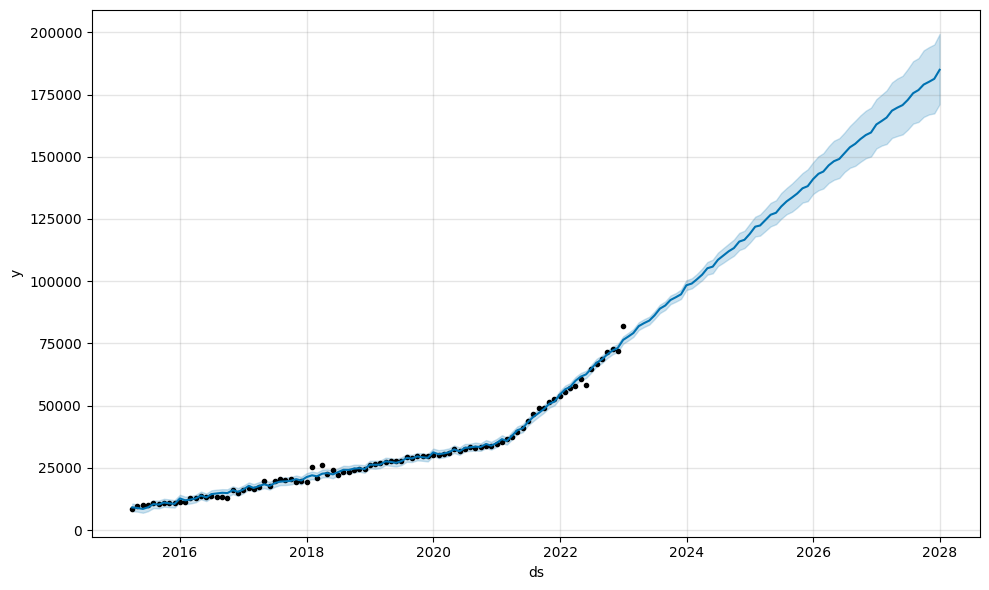

In [104]:
#Prévision du nombre de Points de charge à 5 ans
future = model.make_future_dataframe(periods=60, freq='M')
forecast = model.predict(future)
fig = model.plot(forecast)
fig.savefig('images/forecast_prophet_pdc.png')

In [105]:
#Affichage des 5 derniers mois de prévision
forecast_pdc = model.predict(future)
forecast_pdc[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds           yhat     yhat_lower     yhat_upper
149 2027-08-31  176796.766547  163744.173600  190687.708482
150 2027-09-30  179001.428259  165720.369335  193281.821518
151 2027-10-31  180117.462751  166274.542134  194672.315557
152 2027-11-30  181296.417546  166888.174089  196295.308252
153 2027-12-31  184934.963007  170493.119242  199883.427818

In [106]:
#Sauvegarde 
forecast_pdc.to_csv('enriched_data/forecast_pdc.csv')

# Conclusion prédictions

100 000 points de charge fin 2024